In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch import autograd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torch.autograd.variable import Variable
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms

# from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
# Parameters
batch_size = 10
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 25
pool_size = 2
num_classes = 10


### 2. Data Preparation



In [3]:


#Define transformations for the training set, flip the images randomly, crop out and apply mean and std normalization
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

#Load the training set
train_set =CIFAR10(root="./data",train=True,transform=train_transformations,download=True)

#Create a loder for the training set

train_loader = Data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=4)

Files already downloaded and verified


In [4]:
# Define transformations for the test set
test_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])

# Load the test set, note that train is set to False
test_set = CIFAR10(root="./data", train=False, transform=test_transformations, download=True)

# Create a loder for the test set, note that both shuffle is set to false for the test loader
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified


truck  bird   car  frog truck   cat  frog   dog  frog  ship


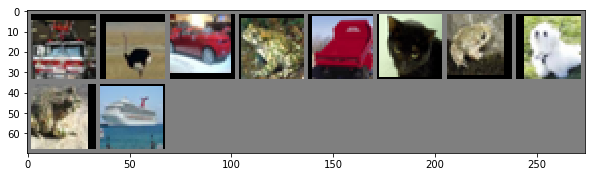

In [5]:

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,8))
    plt.subplots_adjust(wspace=0.6, hspace=0.4)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))



In [6]:
# Create a learning rate adjustment function that divides the learning rate by 10 every 30 epochs
def adjust_learning_rate(epoch):
    lr = learning_rate

    if epoch > 180:
        lr = lr / 1000000
    elif epoch > 150:
        lr = lr / 100000
    elif epoch > 40:
        lr = lr / 10000
    elif epoch > 30:
        lr = lr / 1000
    elif epoch > 20:
        lr = lr / 100
    elif epoch > 10:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [7]:
class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        

        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

In [8]:
class ConvNetwork(nn.Module):
    def __init__(self,num_classes):
        super(ConvNetwork,self).__init__()

        #Create 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3,out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=32)
        self.unit3 = Unit(in_channels=32, out_channels=32)
        
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=pool_size)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=pool_size)

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.unit13 = Unit(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
#         self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
#                                  ,self.unit7, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, self.pool3,
#                                  self.unit12, self.unit13, self.unit14, self.avgpool)
        self.net = nn.Sequential(self.unit1, self.pool1, self.unit4, self.pool2
                                 ,self.unit8,self.pool3, self.avgpool)


        self.fc = nn.Linear(in_features=128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128)
        output = self.fc(output)

        return output

In [9]:
def train(num_epochs):
    best_acc = 0.0
    test_accuracies = []
    train_losses = []
    for epoch in range(num_epochs):
        print('-'*10)
        print("\nEpoch {}/{} \n".format(epoch+1,num_epochs))
        train_acc = 0.0
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            # Move images and labels to gpu if available
            # Clear all accumulated gradients
            model.train()
            optimizer.zero_grad()
            # Predict classes using images from the test set
            images = Variable(images)
            labels = Variable(labels)
            outputs = model(images)
            # Compute the loss based on the predictions and actual labels
            loss = criterion(outputs, labels)
            # Backpropagate the loss
            loss.backward()

            # Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss = (train_loss*i + loss.data[0])/(i+1)
            train_losses.append(train_loss)
            _, prediction = torch.max(outputs.data, 1)
            
            train_acc = (i*train_acc +
                         torch.mean(prediction.eq(labels.data).float()))/(i+1)

        # Call the learning rate adjustment function
        adjust_learning_rate(epoch)

        # Evaluate on the test set
        test_acc = test()
        test_accuracies.append(test_acc)
        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
#             save_models(epoch)
            best_acc = test_acc
            

        # Print the metrics
        print("Train Accuracy: {:.6f}% , TrainLoss: {:.4f}, \nTest Accuracy: {:.6f} %".format(train_acc*100, train_loss,test_acc*100))
    print('\n\nbest_acc = {:.4f}% '.format(best_acc*100))
    print("batch_size", batch_size)
    return test_accuracies, train_losses

In [10]:
def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):

        # Predict classes using images from the test set
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)

        test_acc = (i*test_acc +
                    torch.mean(prediction.eq(labels.data).float()))/(i+1)

    # Compute the average acc and loss over all 10000 test images
#     test_acc = test_acc / 10000

    return test_acc

In [11]:
def plot_kernels(tensor, num_cols=3):
    num_rows = 3
    fig = plt.figure(figsize=(num_cols,num_rows))
    i = 0
    for t in tensor:
        print("i= ",i)
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        pilTrans = transforms.ToPILImage()
        pilImg = pilTrans(t)
        ax1.imshow(pilImg, interpolation='none')
        print(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        if i< 8:
            i+=1

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


In [12]:
model = ConvNetwork(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

'\nPast results\nTrain Accuracy: 59.920811% , TrainLoss: 1.1233, \nBest Accuracy: 62.769543 %\n# Parameters\nbatch_size = 32\nlearning_rate = 0.001\nweight_decay = 0.0001\nnum_epochs = 10\npool_size = 2\nnum_classes = 10\n'

In [14]:
if __name__ == "__main__":
    print("Started Training Network")
    test_accuracies, train_losses =  train(num_epochs)
    print("\nFinished !!")
    

Started Training Network
----------

Epoch 1/25 

Train Accuracy: 44.898000% , TrainLoss: 1.5223, 
Test Accuracy: 53.440000 %
----------

Epoch 2/25 

Train Accuracy: 56.272000% , TrainLoss: 1.2299, 
Test Accuracy: 61.860000 %
----------

Epoch 3/25 

Train Accuracy: 60.924000% , TrainLoss: 1.1122, 
Test Accuracy: 62.860000 %
----------

Epoch 4/25 

Train Accuracy: 63.940000% , TrainLoss: 1.0296, 
Test Accuracy: 68.410000 %
----------

Epoch 5/25 

Train Accuracy: 66.274000% , TrainLoss: 0.9703, 
Test Accuracy: 69.310000 %
----------

Epoch 6/25 

Train Accuracy: 68.238000% , TrainLoss: 0.9226, 
Test Accuracy: 69.620000 %
----------

Epoch 7/25 

Train Accuracy: 69.152000% , TrainLoss: 0.8965, 
Test Accuracy: 71.930000 %
----------

Epoch 8/25 

Train Accuracy: 70.144000% , TrainLoss: 0.8605, 
Test Accuracy: 72.830000 %
----------

Epoch 9/25 

Train Accuracy: 71.152000% , TrainLoss: 0.8372, 
Test Accuracy: 73.140000 %
----------

Epoch 10/25 

Train Accuracy: 72.288000% , TrainLoss: 

i=  0

(0 ,.,.) = 
  0.0919 -0.3013  0.3281
  0.2584 -0.1152 -0.1271
 -0.3266  0.1440 -0.1000

(1 ,.,.) = 
  0.0207 -0.3032 -0.0110
  0.3500 -0.0003 -0.3134
  0.0535  0.5217  0.0932

(2 ,.,.) = 
  0.0864 -0.4587 -0.1427
  0.3026  0.0862 -0.4940
  0.0356  0.3953  0.0437
[torch.FloatTensor of size 3x3x3]

i=  1

(0 ,.,.) = 
  0.1792  0.3893  0.4962
 -0.2445  0.0263  0.0872
 -0.5295 -0.2670 -0.0782

(1 ,.,.) = 
 -0.1959 -0.0776 -0.1520
  0.0448 -0.1486  0.0587
  0.2769  0.0649  0.0980

(2 ,.,.) = 
 -0.0427 -0.3977 -0.4772
  0.3116  0.1046 -0.1331
  0.3368  0.2223  0.0068
[torch.FloatTensor of size 3x3x3]

i=  2

(0 ,.,.) = 
 -0.2069  0.1432  0.2686
  0.1106  0.0476 -0.2383
  0.0203 -0.0533 -0.6124

(1 ,.,.) = 
  0.1767  0.2274  0.1284
  0.2878  0.3448  0.0231
  0.4201  0.0362 -0.2125

(2 ,.,.) = 
 -0.2720 -0.1720  0.1743
 -0.2431 -0.2492 -0.1562
  0.0146 -0.2992 -0.4031
[torch.FloatTensor of size 3x3x3]

i=  3

(0 ,.,.) = 
 -0.3193 -0.4569 -0.0005
 -0.3890 -0.0380  0.0191
  0.1665  0.4969

/home/bob/.virtualenvs/virtual-py3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


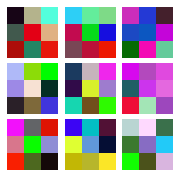

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

(0 ,.,.) = 
1.00000e-02 *
  -0.9107  3.0983  5.7866
   3.8132  1.0569 -0.2531
  -0.3899  3.4924 -1.5728

(1 ,.,.) = 
1.00000e-02 *
   5.1991  5.5873 -2.9152
   1.5701 -2.9430 -1.1069
   1.4264  3.3025 -0.2509

(2 ,.,.) = 
1.00000e-02 *
   0.9081  2.5875 -4.2080
  -4.7873 -0.0617  1.6413
   1.0905  0.4311 -2.2911

(3 ,.,.) = 
1.00000e-02 *
  -0.4809  0.2790 -3.1810
  -4.5340  1.4364 -4.9390
   4.7888 -3.0386  4.1877

(4 ,.,.) = 
1.00000e-02 *
   0.0566 -1.6585 -4.4661
  -2.5067 -2.2189  2.9258
  -4.0992 -0.0458 -2.7747

(5 ,.,.) = 
1.00000e-02 *
   4.1321  2.4210 -4.5813
  -2.9988  2.9186 -1.9788
  -1.0012 -5.4717  2.7096

(6 ,.,.) = 
1.00000e-02 *
  -5.4024 -2.6646 -1.4846
  -0.3643 -4.2923  0.6856
   3.5866 -4.8644 -0.3642

(7 ,.,.) = 
1.00000e-02 *
   0.1780 -1.5093  2.3603
  -2.8465  1.3286 -1.4803
  -2.4342 -4.8816 -3.628


(0 ,.,.) = 
1.00000e-02 *
   3.4461  4.1734 -0.6866
  -3.7043 -3.6428  0.8001
   4.1871 -3.6197 -3.3426

(1 ,.,.) = 
1.00000e-02 *
  -0.0758 -4.0161  2.5070
   5.1895 -2.0544 -0.3502
  -3.5653  2.8965 -2.5901

(2 ,.,.) = 
1.00000e-02 *
  -4.4249  4.5313  4.6361
   4.1203  5.2543 -3.5984
  -4.5479  1.8195 -1.4377

(3 ,.,.) = 
1.00000e-02 *
  -5.4876 -1.9892 -2.5601
   2.2982 -3.8222  2.3446
  -0.5874 -4.9111  1.3361

(4 ,.,.) = 
1.00000e-02 *
  -4.1662 -1.2505 -2.9840
   3.9632  3.0328 -0.6512
  -5.8006  3.6202 -5.0904

(5 ,.,.) = 
1.00000e-02 *
  -5.8135  1.6045 -3.1119
   1.8486  3.5275  4.8592
   2.9567  1.7384 -5.4131

(6 ,.,.) = 
1.00000e-02 *
  -2.0397  0.2467 -2.3793
   2.2869  3.5045 -0.5521
   2.7455  4.8599 -3.9390

(7 ,.,.) = 
1.00000e-02 *
  -3.3573 -1.9583  2.2722
  -1.4906  4.7123 -5.7365
  -3.8124 -0.2606  4.8822

(8 ,.,.) = 
1.00000e-02 *
  -1.1158 -5.2297  4.8010
  -0.3759 -2.0315 -1.7893
  -2.4607 -1.7439 -3.6164

(9 ,.,.) = 
1.00000e-02 *
   3.4769 -1.5904 -2.4130
  

<Figure size 432x288 with 0 Axes>

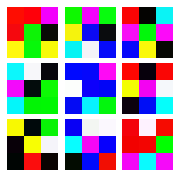

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

(0 ,.,.) = 
1.00000e-02 *
   1.1729 -5.6344 -4.5740
   4.7851 -4.3161  0.0841
  -5.6162  0.4740 -5.5268

(1 ,.,.) = 
1.00000e-02 *
  -2.1786  0.6902  2.7752
  -5.6326 -4.0993 -0.8497
  -1.9171  5.3877 -0.7627

(2 ,.,.) = 
1.00000e-02 *
   0.5127  3.4963  0.0847
   2.8606  0.1301  3.7202
   3.3153 -2.1742 -4.1238

(3 ,.,.) = 
1.00000e-02 *
   0.0717  4.8903 -0.9717
  -2.3392 -3.7964 -0.6638
   4.8259  5.4348 -1.6534

(4 ,.,.) = 
1.00000e-02 *
   5.5819  5.3492  2.6489
  -2.7520 -1.2176  0.4362
   4.6815 -0.7667  5.2428

(5 ,.,.) = 
1.00000e-02 *
  -5.6003  5.2726 -4.2884
  -4.5812 -1.4834 -3.2081
  -3.7152  2.7525 -2.9350

(6 ,.,.) = 
1.00000e-02 *
  -3.2872 -3.4759  4.9646
  -1.4979 -2.2336  1.6973
  -5.8729  0.9810 -2.8382

(7 ,.,.) = 
1.00000e-02 *
   4.4397 -2.2406 -0.2553
   1.0157  2.0667 -0.5459
   5.0212  5.7389 -4.147


(0 ,.,.) = 
1.00000e-02 *
   2.7433  5.6247 -2.5595
   3.5235 -4.7642  0.9778
  -4.0765 -1.3577  0.1441

(1 ,.,.) = 
1.00000e-02 *
   2.7348 -0.2354 -4.7834
  -0.4128  1.2032 -2.9438
   0.7330  4.9906 -1.1145

(2 ,.,.) = 
1.00000e-02 *
   4.6937 -3.6311  4.8039
  -4.7378 -3.6708 -5.6464
   5.2914 -4.4063 -0.5272

(3 ,.,.) = 
1.00000e-02 *
   1.9972 -2.6880 -4.1614
  -3.1276  1.6161  5.5063
  -1.5513 -1.8923  2.2367

(4 ,.,.) = 
1.00000e-02 *
   2.9693  4.3559 -1.7691
  -2.0345  1.0805 -5.2469
  -1.3656  5.1154 -5.4432

(5 ,.,.) = 
1.00000e-02 *
   0.2300 -5.4511  0.4292
  -5.8456 -0.9806 -4.8031
   4.8319  3.6750  2.1603

(6 ,.,.) = 
1.00000e-02 *
   3.3340  5.2157  4.1395
   2.9342 -1.3036  3.7643
   5.4165  4.6574 -0.0649

(7 ,.,.) = 
1.00000e-02 *
  -1.7524  5.0591 -0.0590
   5.1310 -5.2267 -3.3141
  -0.2548  1.2288  4.6922

(8 ,.,.) = 
1.00000e-02 *
   1.2860  1.4081  5.1833
   2.1159  3.7718 -3.9296
  -4.9832  2.1983  2.9554

(9 ,.,.) = 
1.00000e-02 *
  -2.2069  2.3611  5.5267
  


(0 ,.,.) = 
1.00000e-02 *
   2.6456 -1.6224  0.9388
  -0.4460 -3.8445  0.2245
  -0.7478  3.5844 -3.3295

(1 ,.,.) = 
1.00000e-02 *
   0.6764  2.4303  0.8468
  -3.6189  3.2224  3.7423
  -1.5140  0.7758  2.5395

(2 ,.,.) = 
1.00000e-02 *
  -0.0850  4.8719 -5.0338
  -4.3587  4.9211  3.8921
   5.5669  2.9982 -0.7327

(3 ,.,.) = 
1.00000e-02 *
   0.0570  3.8486  0.8791
  -1.4684 -3.2632 -3.9860
   5.1850 -3.8757  1.5021

(4 ,.,.) = 
1.00000e-02 *
  -5.3778  1.5882 -5.2631
  -1.7577  4.5500  1.3020
  -4.1012  1.5748 -0.0836

(5 ,.,.) = 
1.00000e-02 *
   3.9114 -5.5287 -1.4941
   0.3142  1.8206  3.3936
   2.9616 -1.1020  2.1389

(6 ,.,.) = 
1.00000e-02 *
  -4.6432  1.4889  5.2851
  -4.4070  5.1514  0.5677
  -1.7767  2.7191  1.8511

(7 ,.,.) = 
1.00000e-02 *
   0.6437 -4.5095  5.6203
  -1.2579 -3.3345  0.7293
   0.3376 -2.5502 -1.3611

(8 ,.,.) = 
1.00000e-02 *
   5.4970  1.5957 -3.7070
   0.3842 -5.0741  4.8043
  -5.4099 -3.8264  2.4024

(9 ,.,.) = 
1.00000e-02 *
  -5.0500  0.2558  1.6037
  

<Figure size 432x288 with 0 Axes>

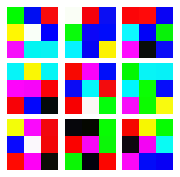

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

(0 ,.,.) = 
 -0.0977 -0.0423 -0.0456
  0.0296 -0.0213 -0.0978
  0.0899 -0.0784  0.1303

(1 ,.,.) = 
  0.1703  0.0936  0.0587
  0.0988  0.1082 -0.0942
  0.0240  0.1368  0.0689

(2 ,.,.) = 
 -0.0073 -0.1839  0.0913
  0.1121 -0.1488 -0.0546
  0.0015 -0.0176 -0.1098

(3 ,.,.) = 
  0.1342  0.0902 -0.2238
  0.1898  0.1445 -0.3232
 -0.0144 -0.0604 -0.2873

(4 ,.,.) = 
  0.0012 -0.3107 -0.1044
  0.1848 -0.3434 -0.0814
 -0.1380  0.0316  0.0072

(5 ,.,.) = 
  0.0707 -0.4435 -0.1111
 -0.0232 -0.4083 -0.1992
  0.1058 -0.2518 -0.0597

(6 ,.,.) = 
 -0.1100  0.0186 -0.1633
 -0.0002  0.0188  0.0600
 -0.0357  0.0092 -0.0670

(7 ,.,.) = 
  0.1461  0.1080 -0.1343
 -0.0915 -0.0953 -0.2755
 -0.0458 -0.1497 -0.2848

(8 ,.,.) = 
  0.2166  0.1142  0.0956
 -0.0247 -0.1265 -0.2197
 -0.0333 -0.0962 -0.1477

(9 ,.,.) = 
 -0.0811 -0.0065 -0.2453
 -0.0572


(0 ,.,.) = 
  0.0831  0.0326 -0.1357
  0.1868 -0.1847 -0.4497
  0.1719 -0.1068 -0.2057

(1 ,.,.) = 
 -0.0981 -0.1251 -0.2104
 -0.0449 -0.2031  0.0784
 -0.0738 -0.2997  0.1245

(2 ,.,.) = 
 -0.0380  0.0098  0.1453
 -0.1005  0.0502  0.1407
 -0.1281 -0.0276  0.1179

(3 ,.,.) = 
  0.1912  0.1861  0.0692
  0.1303  0.0094  0.1130
  0.0929  0.1059  0.1959

(4 ,.,.) = 
  0.1183  0.0446 -0.1837
  0.2750 -0.0007 -0.3368
 -0.1693 -0.2379 -0.3843

(5 ,.,.) = 
  0.0590  0.0280  0.0028
 -0.0023 -0.0342 -0.1595
  0.0084 -0.0925 -0.3064

(6 ,.,.) = 
 -0.1714 -0.2519 -0.1327
 -0.1821 -0.1578 -0.0671
  0.0687  0.2173  0.0629

(7 ,.,.) = 
 -0.1247 -0.0522  0.0280
 -0.2105 -0.0885 -0.0183
 -0.0864  0.1213  0.0505

(8 ,.,.) = 
  0.0910  0.0809  0.0409
  0.0743  0.1059 -0.1445
  0.0970 -0.0291 -0.2498

(9 ,.,.) = 
  0.0455 -0.0022 -0.0401
 -0.0131  0.0031 -0.0810
 -0.0235  0.0175 -0.0673

(10,.,.) = 
 -0.1947 -0.2657  0.0714
 -0.1837 -0.0955 -0.0298
  0.0107  0.1346  0.0953

(11,.,.) = 
 -0.0929  0.0520 -0

i=  8

(0 ,.,.) = 
 -0.1791  0.0420 -0.1142
 -0.0784  0.0071 -0.2012
 -0.1694 -0.1300 -0.3437

(1 ,.,.) = 
 -0.2510 -0.1609  0.0186
 -0.1790 -0.0372  0.1198
 -0.2035  0.0414  0.2530

(2 ,.,.) = 
  0.0138  0.0774  0.1463
  0.0113  0.0401 -0.0016
  0.0042 -0.0211  0.0177

(3 ,.,.) = 
  0.1014 -0.0279  0.0838
  0.0201  0.1155  0.1510
 -0.0803  0.0933  0.0648

(4 ,.,.) = 
  0.0738 -0.0555  0.0232
 -0.0265 -0.1990 -0.0830
 -0.0720 -0.4289 -0.2488

(5 ,.,.) = 
  0.0425  0.0015  0.1485
  0.0554 -0.0105  0.0294
  0.0218 -0.0354 -0.0726

(6 ,.,.) = 
 -0.1953 -0.1196  0.0071
 -0.1457 -0.1070 -0.0668
 -0.2225 -0.2711 -0.1607

(7 ,.,.) = 
  0.0379  0.0836  0.1407
  0.1170  0.1515  0.0831
  0.0613  0.1195 -0.0149

(8 ,.,.) = 
 -0.0930 -0.0567 -0.1893
  0.0161  0.0209 -0.1575
 -0.0787 -0.0571 -0.1169

(9 ,.,.) = 
  0.0779  0.0395 -0.0247
  0.0144  0.0451 -0.0106
 -0.1145 -0.0428 -0.1887

(10,.,.) = 
  0.0223 -0.0223 -0.0050
  0.1214 -0.0183 -0.1643
  0.3152 -0.2085 -0.1577

(11,.,.) = 
 -0.3528 -0.4

i=  8

(0 ,.,.) = 
 -0.1791  0.0420 -0.1142
 -0.0784  0.0071 -0.2012
 -0.1694 -0.1300 -0.3437

(1 ,.,.) = 
 -0.2510 -0.1609  0.0186
 -0.1790 -0.0372  0.1198
 -0.2035  0.0414  0.2530

(2 ,.,.) = 
  0.0138  0.0774  0.1463
  0.0113  0.0401 -0.0016
  0.0042 -0.0211  0.0177

(3 ,.,.) = 
  0.1014 -0.0279  0.0838
  0.0201  0.1155  0.1510
 -0.0803  0.0933  0.0648

(4 ,.,.) = 
  0.0738 -0.0555  0.0232
 -0.0265 -0.1990 -0.0830
 -0.0720 -0.4289 -0.2488

(5 ,.,.) = 
  0.0425  0.0015  0.1485
  0.0554 -0.0105  0.0294
  0.0218 -0.0354 -0.0726

(6 ,.,.) = 
 -0.1953 -0.1196  0.0071
 -0.1457 -0.1070 -0.0668
 -0.2225 -0.2711 -0.1607

(7 ,.,.) = 
  0.0379  0.0836  0.1407
  0.1170  0.1515  0.0831
  0.0613  0.1195 -0.0149

(8 ,.,.) = 
 -0.0930 -0.0567 -0.1893
  0.0161  0.0209 -0.1575
 -0.0787 -0.0571 -0.1169

(9 ,.,.) = 
  0.0779  0.0395 -0.0247
  0.0144  0.0451 -0.0106
 -0.1145 -0.0428 -0.1887

(10,.,.) = 
  0.0223 -0.0223 -0.0050
  0.1214 -0.0183 -0.1643
  0.3152 -0.2085 -0.1577

(11,.,.) = 
 -0.3528 -0.4

i=  8

(0 ,.,.) = 
 -0.1791  0.0420 -0.1142
 -0.0784  0.0071 -0.2012
 -0.1694 -0.1300 -0.3437

(1 ,.,.) = 
 -0.2510 -0.1609  0.0186
 -0.1790 -0.0372  0.1198
 -0.2035  0.0414  0.2530

(2 ,.,.) = 
  0.0138  0.0774  0.1463
  0.0113  0.0401 -0.0016
  0.0042 -0.0211  0.0177

(3 ,.,.) = 
  0.1014 -0.0279  0.0838
  0.0201  0.1155  0.1510
 -0.0803  0.0933  0.0648

(4 ,.,.) = 
  0.0738 -0.0555  0.0232
 -0.0265 -0.1990 -0.0830
 -0.0720 -0.4289 -0.2488

(5 ,.,.) = 
  0.0425  0.0015  0.1485
  0.0554 -0.0105  0.0294
  0.0218 -0.0354 -0.0726

(6 ,.,.) = 
 -0.1953 -0.1196  0.0071
 -0.1457 -0.1070 -0.0668
 -0.2225 -0.2711 -0.1607

(7 ,.,.) = 
  0.0379  0.0836  0.1407
  0.1170  0.1515  0.0831
  0.0613  0.1195 -0.0149

(8 ,.,.) = 
 -0.0930 -0.0567 -0.1893
  0.0161  0.0209 -0.1575
 -0.0787 -0.0571 -0.1169

(9 ,.,.) = 
  0.0779  0.0395 -0.0247
  0.0144  0.0451 -0.0106
 -0.1145 -0.0428 -0.1887

(10,.,.) = 
  0.0223 -0.0223 -0.0050
  0.1214 -0.0183 -0.1643
  0.3152 -0.2085 -0.1577

(11,.,.) = 
 -0.3528 -0.4

<Figure size 432x288 with 0 Axes>

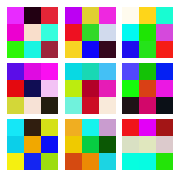

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

(0 ,.,.) = 
1.00000e-02 *
   3.0677  0.5877  4.0110
   1.2260  0.3756  0.4413
   2.3581 -1.3582  3.4083

(1 ,.,.) = 
1.00000e-02 *
  -1.6223  0.7110 -2.9825
   2.1779 -4.0495 -2.9833
   1.4892 -3.3117  2.9016

(2 ,.,.) = 
1.00000e-02 *
  -3.3202  3.8414 -0.8465
   3.8074 -3.1995 -2.5123
  -3.1697  1.3234  1.0613

(3 ,.,.) = 
1.00000e-02 *
  -1.0880  1.4587  0.8719
  -2.5495  0.5289  0.5303
   0.4895  2.0389 -0.4418

(4 ,.,.) = 
1.00000e-02 *
  -3.6906  1.8645 -3.0185
  -0.3316  1.4345  4.0955
  -1.4074 -0.4826 -1.7293

(5 ,.,.) = 
1.00000e-02 *
   3.9905  1.4268 -3.6830
   3.9406  1.3879  0.9903
  -1.6239  3.5732 -3.0133

(6 ,.,.) = 
1.00000e-02 *
   2.6074 -2.3817  0.1303
  -0.0159 -1.5522  3.9562
   0.4383 -0.2370  0.8622

(7 ,.,.) = 
1.00000e-02 *
   2.2209 -1.0977 -0.6138
   1.3173  1.5918  0.6716
  -1.2208  0.1650 -1.547

i=  7

(0 ,.,.) = 
1.00000e-02 *
   1.2523 -1.1209 -4.1582
   0.8776 -0.1440 -1.1348
  -1.8008  2.9521  2.1901

(1 ,.,.) = 
1.00000e-02 *
   2.7554 -1.5690 -1.3738
  -3.7337 -3.8244 -0.6829
  -0.3110  2.1198  3.8025

(2 ,.,.) = 
1.00000e-02 *
  -2.5890 -0.6098  0.5250
   2.7180  2.9120 -3.8648
   4.1334  3.2441  1.5718

(3 ,.,.) = 
1.00000e-02 *
  -1.1000 -0.8953 -2.7802
   4.0433 -1.5812  0.2941
  -0.4032  0.1403 -3.9950

(4 ,.,.) = 
1.00000e-02 *
  -3.7467 -0.6659  2.6906
   3.2465 -0.0975 -0.8858
   2.5932 -0.1981 -2.0111

(5 ,.,.) = 
1.00000e-02 *
  -0.9286 -2.7847  3.1304
  -2.1651  2.0786  0.0312
   2.7128  1.6829 -0.4789

(6 ,.,.) = 
1.00000e-02 *
   3.7922  2.9218 -3.6634
   3.0919 -2.6823 -3.3160
   1.3580 -0.5516  2.6181

(7 ,.,.) = 
1.00000e-02 *
  -3.7970 -1.9240  0.5732
  -3.7085  3.1547 -2.1286
  -1.8838 -3.1804 -3.7654

(8 ,.,.) = 
1.00000e-02 *
   2.2039  2.4849 -2.0690
  -0.8015 -1.9658  3.3928
   1.9930  1.2881  3.3994

(9 ,.,.) = 
1.00000e-02 *
  -1.0574 -0.1498  2.0


(0 ,.,.) = 
1.00000e-02 *
  -0.3469 -1.1981  2.4282
   3.9157  1.1136  0.4697
   1.9972  0.9960  3.8532

(1 ,.,.) = 
1.00000e-02 *
   0.6164 -0.9561  2.2792
  -2.3934  1.6525  4.1641
   3.3689 -2.3333  2.5066

(2 ,.,.) = 
1.00000e-02 *
  -1.2437  1.4103  3.1963
  -2.8620 -2.7933 -4.0524
   2.6318 -0.9926 -0.2183

(3 ,.,.) = 
1.00000e-02 *
   1.9296 -3.4939 -0.1922
   4.0595 -3.0727 -1.3914
  -0.4341  0.1594  1.5294

(4 ,.,.) = 
1.00000e-02 *
   0.4375  0.3789 -0.6039
   2.3017  1.5430  4.0071
  -1.4487  2.1055 -3.1454

(5 ,.,.) = 
1.00000e-02 *
  -3.7116 -2.0854 -1.7069
  -1.7073 -2.9229 -1.4398
  -3.1766 -0.5571  4.0396

(6 ,.,.) = 
1.00000e-02 *
  -3.0734 -0.0049 -2.1504
  -3.8831 -3.2745  2.2530
   3.9506 -4.0944 -4.1226

(7 ,.,.) = 
1.00000e-02 *
   2.0807  2.5431 -1.2827
  -0.8720  0.1737  3.6976
   1.3504 -2.5704  4.1178

(8 ,.,.) = 
1.00000e-02 *
   0.5144  3.6295  1.7587
  -1.6450 -1.9200  2.9226
   0.7450  1.9503 -4.0276

(9 ,.,.) = 
1.00000e-02 *
  -1.2331  2.2608  0.1941
  


(0 ,.,.) = 
1.00000e-02 *
  -0.3469 -1.1981  2.4282
   3.9157  1.1136  0.4697
   1.9972  0.9960  3.8532

(1 ,.,.) = 
1.00000e-02 *
   0.6164 -0.9561  2.2792
  -2.3934  1.6525  4.1641
   3.3689 -2.3333  2.5066

(2 ,.,.) = 
1.00000e-02 *
  -1.2437  1.4103  3.1963
  -2.8620 -2.7933 -4.0524
   2.6318 -0.9926 -0.2183

(3 ,.,.) = 
1.00000e-02 *
   1.9296 -3.4939 -0.1922
   4.0595 -3.0727 -1.3914
  -0.4341  0.1594  1.5294

(4 ,.,.) = 
1.00000e-02 *
   0.4375  0.3789 -0.6039
   2.3017  1.5430  4.0071
  -1.4487  2.1055 -3.1454

(5 ,.,.) = 
1.00000e-02 *
  -3.7116 -2.0854 -1.7069
  -1.7073 -2.9229 -1.4398
  -3.1766 -0.5571  4.0396

(6 ,.,.) = 
1.00000e-02 *
  -3.0734 -0.0049 -2.1504
  -3.8831 -3.2745  2.2530
   3.9506 -4.0944 -4.1226

(7 ,.,.) = 
1.00000e-02 *
   2.0807  2.5431 -1.2827
  -0.8720  0.1737  3.6976
   1.3504 -2.5704  4.1178

(8 ,.,.) = 
1.00000e-02 *
   0.5144  3.6295  1.7587
  -1.6450 -1.9200  2.9226
   0.7450  1.9503 -4.0276

(9 ,.,.) = 
1.00000e-02 *
  -1.2331  2.2608  0.1941
  

<Figure size 432x288 with 0 Axes>

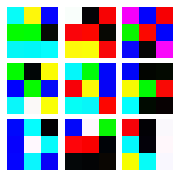

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

(0 ,.,.) = 
1.00000e-02 *
  -0.0444  1.0630  1.2804
  -3.7131  1.7609  1.9118
   2.2051  1.9951  0.2975

(1 ,.,.) = 
1.00000e-02 *
  -0.0114 -2.2708 -3.7926
  -1.9876  3.3217 -2.7680
  -0.7185 -3.6751 -3.7671

(2 ,.,.) = 
1.00000e-02 *
  -3.0571  3.9629 -3.5972
   0.2749 -2.1529  3.7805
   0.1718 -4.0835 -1.2250

(3 ,.,.) = 
1.00000e-02 *
   1.6637 -2.7265 -4.0412
   2.7753 -3.1891  1.6491
   2.0647 -3.6808  3.0949

(4 ,.,.) = 
1.00000e-02 *
   3.1742 -1.8405 -3.0981
  -1.3003  1.4568  2.4707
   1.5335  3.9399 -0.0872

(5 ,.,.) = 
1.00000e-02 *
   0.5822  0.1796 -0.1856
   3.6309 -3.1930 -2.3345
  -0.3606 -0.8307 -1.7787

(6 ,.,.) = 
1.00000e-02 *
   2.3588 -0.3136 -0.2464
   2.7333  2.2336  0.7454
   0.4900  0.7992  1.3491

(7 ,.,.) = 
1.00000e-02 *
   1.2344 -3.2914  3.5396
   3.7136  1.7687  2.9986
   0.1432 -3.8061 -3.084


(0 ,.,.) = 
1.00000e-02 *
   3.2413  3.1423  3.3307
  -0.7584  2.6828 -2.9518
   2.6395 -2.1205 -3.2495

(1 ,.,.) = 
1.00000e-02 *
   0.5639 -1.3507 -0.5169
   2.4640  0.3824  2.2486
   2.2587 -2.6262 -0.4917

(2 ,.,.) = 
1.00000e-02 *
   0.0115 -3.5804  0.8224
  -2.3183 -2.1660 -3.7902
  -2.8567  3.7012  0.3995

(3 ,.,.) = 
1.00000e-02 *
  -3.2531  1.0249 -2.5451
   1.4189  3.8964 -2.1110
   4.1498 -0.0749 -0.0068

(4 ,.,.) = 
1.00000e-02 *
   1.7230 -2.9385  0.7336
  -0.9452 -3.0711  3.6699
  -2.4384  4.1478  1.5244

(5 ,.,.) = 
1.00000e-02 *
  -3.1813  1.0688 -0.5905
  -2.1744 -3.3371  0.3855
   0.6197  3.1667 -3.4153

(6 ,.,.) = 
1.00000e-02 *
   2.4793  1.0013  3.2976
  -2.7781  1.7432 -2.5844
  -3.1911 -2.6858 -4.0949

(7 ,.,.) = 
1.00000e-02 *
  -2.6250  0.7147 -3.1644
   2.7991  0.9988 -1.0606
  -3.9363 -2.5211 -0.0680

(8 ,.,.) = 
1.00000e-02 *
  -0.0681 -1.0523  4.1020
   0.7459  3.0041 -2.4550
   2.9517 -2.3936 -1.7157

(9 ,.,.) = 
1.00000e-02 *
  -3.5707  0.4453  2.8477
  

i=  8

(0 ,.,.) = 
1.00000e-02 *
   1.7669  2.8730 -2.3277
   2.7576 -0.6560  2.7053
   1.7261 -1.7961 -0.1569

(1 ,.,.) = 
1.00000e-02 *
   0.5453 -2.8271 -2.1627
  -0.2247  2.7748 -0.6368
  -2.0536  2.8210  2.0190

(2 ,.,.) = 
1.00000e-02 *
  -0.7908  3.5118 -0.6610
   0.1007 -4.0895 -1.5730
   0.3747  3.0401  3.4072

(3 ,.,.) = 
1.00000e-02 *
  -1.3085  4.0947  3.0284
  -0.3955 -0.8022  1.4624
  -0.9568 -3.3783  3.1572

(4 ,.,.) = 
1.00000e-02 *
  -3.0535  2.4825  3.0865
   3.5920 -3.2013  0.4579
  -2.3555  1.9563  3.6877

(5 ,.,.) = 
1.00000e-02 *
   3.1727  2.9503  0.6611
   0.6097 -2.3445 -1.5085
  -0.1201 -3.9971 -1.6308

(6 ,.,.) = 
1.00000e-02 *
  -1.9809 -2.8938 -0.4691
  -3.0831  2.5762 -3.1305
   0.0072 -1.9831  0.4184

(7 ,.,.) = 
1.00000e-02 *
  -2.1697  0.6403  0.5526
   0.2442  1.0192 -2.0705
  -2.8082 -1.5400 -2.2566

(8 ,.,.) = 
1.00000e-02 *
  -2.0892  2.4139  1.8294
  -3.5122 -3.4055  0.8403
  -3.5159 -3.0978  1.4614

(9 ,.,.) = 
1.00000e-02 *
  -2.8636  1.0396 -0.1


(0 ,.,.) = 
1.00000e-02 *
   1.7669  2.8730 -2.3277
   2.7576 -0.6560  2.7053
   1.7261 -1.7961 -0.1569

(1 ,.,.) = 
1.00000e-02 *
   0.5453 -2.8271 -2.1627
  -0.2247  2.7748 -0.6368
  -2.0536  2.8210  2.0190

(2 ,.,.) = 
1.00000e-02 *
  -0.7908  3.5118 -0.6610
   0.1007 -4.0895 -1.5730
   0.3747  3.0401  3.4072

(3 ,.,.) = 
1.00000e-02 *
  -1.3085  4.0947  3.0284
  -0.3955 -0.8022  1.4624
  -0.9568 -3.3783  3.1572

(4 ,.,.) = 
1.00000e-02 *
  -3.0535  2.4825  3.0865
   3.5920 -3.2013  0.4579
  -2.3555  1.9563  3.6877

(5 ,.,.) = 
1.00000e-02 *
   3.1727  2.9503  0.6611
   0.6097 -2.3445 -1.5085
  -0.1201 -3.9971 -1.6308

(6 ,.,.) = 
1.00000e-02 *
  -1.9809 -2.8938 -0.4691
  -3.0831  2.5762 -3.1305
   0.0072 -1.9831  0.4184

(7 ,.,.) = 
1.00000e-02 *
  -2.1697  0.6403  0.5526
   0.2442  1.0192 -2.0705
  -2.8082 -1.5400 -2.2566

(8 ,.,.) = 
1.00000e-02 *
  -2.0892  2.4139  1.8294
  -3.5122 -3.4055  0.8403
  -3.5159 -3.0978  1.4614

(9 ,.,.) = 
1.00000e-02 *
  -2.8636  1.0396 -0.1878
  

i=  8

(0 ,.,.) = 
1.00000e-02 *
   1.7669  2.8730 -2.3277
   2.7576 -0.6560  2.7053
   1.7261 -1.7961 -0.1569

(1 ,.,.) = 
1.00000e-02 *
   0.5453 -2.8271 -2.1627
  -0.2247  2.7748 -0.6368
  -2.0536  2.8210  2.0190

(2 ,.,.) = 
1.00000e-02 *
  -0.7908  3.5118 -0.6610
   0.1007 -4.0895 -1.5730
   0.3747  3.0401  3.4072

(3 ,.,.) = 
1.00000e-02 *
  -1.3085  4.0947  3.0284
  -0.3955 -0.8022  1.4624
  -0.9568 -3.3783  3.1572

(4 ,.,.) = 
1.00000e-02 *
  -3.0535  2.4825  3.0865
   3.5920 -3.2013  0.4579
  -2.3555  1.9563  3.6877

(5 ,.,.) = 
1.00000e-02 *
   3.1727  2.9503  0.6611
   0.6097 -2.3445 -1.5085
  -0.1201 -3.9971 -1.6308

(6 ,.,.) = 
1.00000e-02 *
  -1.9809 -2.8938 -0.4691
  -3.0831  2.5762 -3.1305
   0.0072 -1.9831  0.4184

(7 ,.,.) = 
1.00000e-02 *
  -2.1697  0.6403  0.5526
   0.2442  1.0192 -2.0705
  -2.8082 -1.5400 -2.2566

(8 ,.,.) = 
1.00000e-02 *
  -2.0892  2.4139  1.8294
  -3.5122 -3.4055  0.8403
  -3.5159 -3.0978  1.4614

(9 ,.,.) = 
1.00000e-02 *
  -2.8636  1.0396 -0.1

<Figure size 432x288 with 0 Axes>

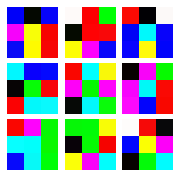

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

(0 ,.,.) = 
1.00000e-02 *
  -1.2568 -2.1457  3.1529
   2.1973  1.8300 -2.5619
   2.8595  0.9968  1.7146

(1 ,.,.) = 
1.00000e-02 *
  -1.1626  1.8188  2.0853
  -3.5972 -2.3794 -3.4653
   2.8840 -0.7243 -1.3087

(2 ,.,.) = 
1.00000e-02 *
   1.7015 -2.1927 -0.1308
  -0.5308  0.7794  1.7257
   2.1853 -3.6425  2.0498

(3 ,.,.) = 
1.00000e-02 *
  -2.3122  3.3007  1.1900
   0.2878  3.4649  2.3677
  -4.0599  1.9109  1.9350

(4 ,.,.) = 
1.00000e-02 *
   2.7747 -2.2952  2.0637
  -2.2106 -4.1010  0.0957
   1.9853 -2.1050  3.7427

(5 ,.,.) = 
1.00000e-02 *
  -3.0133 -1.5598  3.9939
  -3.2551  2.5813  2.3784
   3.3804  0.3910 -3.4838

(6 ,.,.) = 
1.00000e-02 *
  -2.4350  2.0317 -1.2065
  -3.6507 -1.4603 -0.1926
   0.3074 -3.1739  0.7949

(7 ,.,.) = 
1.00000e-02 *
  -1.9086  1.7634  1.4562
   2.2569  3.3379  4.0413
  -2.4329 -1.9648 -0.095

i=  6

(0 ,.,.) = 
1.00000e-02 *
   2.8855 -2.1265  0.1048
  -3.6043  3.5395 -3.2220
   1.6458 -1.3753 -1.5228

(1 ,.,.) = 
1.00000e-02 *
   2.5449 -1.8538  2.9283
   0.9497  3.0198  1.4049
   3.7202 -0.2351  3.1568

(2 ,.,.) = 
1.00000e-02 *
  -1.9562 -1.0853 -2.8061
  -2.5412  3.0019 -0.5546
  -0.4155 -0.3650  2.4301

(3 ,.,.) = 
1.00000e-02 *
  -2.3585  1.7779 -2.8154
   1.2439  2.3991 -3.9077
   1.4155  1.3167 -3.8715

(4 ,.,.) = 
1.00000e-02 *
  -2.4929  0.9503 -3.1242
  -2.9170  4.0280 -0.7940
   1.1511  1.2435  0.4133

(5 ,.,.) = 
1.00000e-02 *
   0.8539 -2.0183 -1.5583
   3.8379  3.6599 -0.3066
   3.7614 -1.6251  2.0841

(6 ,.,.) = 
1.00000e-02 *
   3.1430 -3.2390 -1.9561
   3.5472  2.4679  2.2177
   1.5892 -0.1340 -0.3274

(7 ,.,.) = 
1.00000e-02 *
  -2.0834 -1.6442 -0.8608
  -3.2833  1.5528  1.9340
   1.6640  2.7928 -1.9979

(8 ,.,.) = 
1.00000e-02 *
   1.5175 -0.0099 -0.1215
  -1.1512  0.1622 -0.4214
  -2.0153 -2.7263  1.8358

(9 ,.,.) = 
1.00000e-02 *
  -3.4047 -3.9252 -2.9


(0 ,.,.) = 
1.00000e-02 *
   2.6290 -2.2046 -1.9634
   2.4390  1.2349 -2.1959
  -0.2193  1.9394  0.0404

(1 ,.,.) = 
1.00000e-02 *
   3.3924 -4.0385  2.8937
  -1.2685  1.0816 -3.7532
   1.6535 -1.1770 -3.6310

(2 ,.,.) = 
1.00000e-02 *
   2.4237  2.1820  2.3883
   0.2692  1.2961 -1.9676
   2.5101  3.0321  1.7525

(3 ,.,.) = 
1.00000e-02 *
  -1.2727 -2.3248  1.8569
   2.6849 -0.1958 -0.7874
   0.7157 -1.0135 -1.3744

(4 ,.,.) = 
1.00000e-02 *
  -2.2148  0.6070  0.7302
   2.3814  3.7254 -1.2845
  -2.2200 -1.0720  2.9115

(5 ,.,.) = 
1.00000e-02 *
   1.1242 -2.7232  1.9996
   2.6160  1.9384 -3.7859
  -2.1208  0.0275 -2.4885

(6 ,.,.) = 
1.00000e-02 *
   1.6817  3.9910  0.5599
   3.3898 -1.1107  3.0599
   2.2393 -2.3676 -3.8318

(7 ,.,.) = 
1.00000e-02 *
  -0.9517 -1.6365  3.1984
  -3.2693 -0.7149  2.6479
   2.8782  3.9817 -0.9956

(8 ,.,.) = 
1.00000e-02 *
  -2.8148  1.1155  0.1454
  -0.7778 -2.3882  2.1555
  -0.0994  0.1191  1.7982

(9 ,.,.) = 
1.00000e-02 *
  -3.9899 -3.1975  0.8470
  


(0 ,.,.) = 
1.00000e-02 *
   2.6290 -2.2046 -1.9634
   2.4390  1.2349 -2.1959
  -0.2193  1.9394  0.0404

(1 ,.,.) = 
1.00000e-02 *
   3.3924 -4.0385  2.8937
  -1.2685  1.0816 -3.7532
   1.6535 -1.1770 -3.6310

(2 ,.,.) = 
1.00000e-02 *
   2.4237  2.1820  2.3883
   0.2692  1.2961 -1.9676
   2.5101  3.0321  1.7525

(3 ,.,.) = 
1.00000e-02 *
  -1.2727 -2.3248  1.8569
   2.6849 -0.1958 -0.7874
   0.7157 -1.0135 -1.3744

(4 ,.,.) = 
1.00000e-02 *
  -2.2148  0.6070  0.7302
   2.3814  3.7254 -1.2845
  -2.2200 -1.0720  2.9115

(5 ,.,.) = 
1.00000e-02 *
   1.1242 -2.7232  1.9996
   2.6160  1.9384 -3.7859
  -2.1208  0.0275 -2.4885

(6 ,.,.) = 
1.00000e-02 *
   1.6817  3.9910  0.5599
   3.3898 -1.1107  3.0599
   2.2393 -2.3676 -3.8318

(7 ,.,.) = 
1.00000e-02 *
  -0.9517 -1.6365  3.1984
  -3.2693 -0.7149  2.6479
   2.8782  3.9817 -0.9956

(8 ,.,.) = 
1.00000e-02 *
  -2.8148  1.1155  0.1454
  -0.7778 -2.3882  2.1555
  -0.0994  0.1191  1.7982

(9 ,.,.) = 
1.00000e-02 *
  -3.9899 -3.1975  0.8470
  

i=  8

(0 ,.,.) = 
1.00000e-02 *
   2.6290 -2.2046 -1.9634
   2.4390  1.2349 -2.1959
  -0.2193  1.9394  0.0404

(1 ,.,.) = 
1.00000e-02 *
   3.3924 -4.0385  2.8937
  -1.2685  1.0816 -3.7532
   1.6535 -1.1770 -3.6310

(2 ,.,.) = 
1.00000e-02 *
   2.4237  2.1820  2.3883
   0.2692  1.2961 -1.9676
   2.5101  3.0321  1.7525

(3 ,.,.) = 
1.00000e-02 *
  -1.2727 -2.3248  1.8569
   2.6849 -0.1958 -0.7874
   0.7157 -1.0135 -1.3744

(4 ,.,.) = 
1.00000e-02 *
  -2.2148  0.6070  0.7302
   2.3814  3.7254 -1.2845
  -2.2200 -1.0720  2.9115

(5 ,.,.) = 
1.00000e-02 *
   1.1242 -2.7232  1.9996
   2.6160  1.9384 -3.7859
  -2.1208  0.0275 -2.4885

(6 ,.,.) = 
1.00000e-02 *
   1.6817  3.9910  0.5599
   3.3898 -1.1107  3.0599
   2.2393 -2.3676 -3.8318

(7 ,.,.) = 
1.00000e-02 *
  -0.9517 -1.6365  3.1984
  -3.2693 -0.7149  2.6479
   2.8782  3.9817 -0.9956

(8 ,.,.) = 
1.00000e-02 *
  -2.8148  1.1155  0.1454
  -0.7778 -2.3882  2.1555
  -0.0994  0.1191  1.7982

(9 ,.,.) = 
1.00000e-02 *
  -3.9899 -3.1975  0.8

<Figure size 432x288 with 0 Axes>

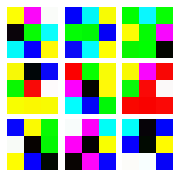

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

(0 ,.,.) = 
  7.4185e-02  1.3438e-01 -9.9621e-02
  1.1384e-01  2.0292e-01 -5.1599e-02
  1.1469e-01  1.1160e-01  2.7037e-02

(1 ,.,.) = 
 -6.5053e-02 -3.7521e-03  5.1225e-02
 -1.6438e-01 -1.4080e-01  2.9976e-05
 -7.7987e-02 -1.1031e-01 -2.9020e-02

(2 ,.,.) = 
 -2.7325e-02  5.7415e-02 -1.8943e-02
  3.5663e-02  5.7969e-02 -6.2845e-03
 -4.4738e-03  3.9212e-02  5.3658e-02

(3 ,.,.) = 
  2.5199e-02  1.4427e-01 -5.7446e-02
  1.0212e-02  1.5304e-01  1.7488e-02
 -1.3033e-02 -2.2876e-02 -5.6142e-03

(4 ,.,.) = 
  8.2311e-02  3.2087e-02  2.4951e-02
  8.0567e-03  3.4238e-02  1.3281e-01
  1.8681e-02  2.6759e-02  4.1527e-02

(5 ,.,.) = 
  4.4014e-02  1.9294e-01 -9.7356e-02
 -5.4747e-02  5.2125e-02 -1.5813e-01
 -6.8669e-02  6.7126e-02 -7.8456e-02

(6 ,.,.) = 
 -1.6875e-01 -1.1094e-01 -5.1973e-02
 -1.2886e-01 -8.0520e-02  3.0185e-02
  1.015


(0 ,.,.) = 
 -1.1310e-01  7.0663e-03  1.1645e-01
 -2.5505e-01 -1.1246e-01  9.5885e-02
 -2.9798e-01 -2.4024e-01 -3.6955e-03

(1 ,.,.) = 
 -1.1371e-01 -1.6027e-01  2.8155e-03
 -8.7355e-02 -1.3992e-01  2.3430e-02
 -8.8705e-02 -1.0398e-01  3.0855e-02

(2 ,.,.) = 
  4.4401e-02 -1.4756e-01 -5.9731e-02
  4.0984e-02 -1.9052e-01 -7.1998e-02
  3.6499e-02 -1.0538e-01  3.0602e-03

(3 ,.,.) = 
 -1.5140e-01 -2.5604e-03  7.5420e-02
 -1.2281e-01 -1.0222e-01 -2.3985e-02
 -1.9563e-01 -1.6167e-01 -1.0238e-01

(4 ,.,.) = 
 -9.3066e-02  4.1338e-02 -5.9120e-02
 -6.2241e-02 -1.8395e-02 -9.3212e-02
 -7.8356e-02 -1.2993e-01 -8.9010e-02

(5 ,.,.) = 
 -2.5197e-01 -1.8022e-01 -6.1036e-04
 -2.5383e-01 -1.7881e-01  1.3553e-01
 -1.2636e-01 -6.9998e-02  5.6154e-02

(6 ,.,.) = 
  1.0933e-01  2.4192e-02 -6.8826e-02
 -4.0199e-03 -3.5328e-02 -1.0171e-01
 -1.4222e-01 -1.4051e-01 -7.4472e-02

(7 ,.,.) = 
  1.2384e-02 -6.8041e-02 -1.3308e-01
 -1.4124e-01 -1.7282e-01 -4.4576e-02
 -1.6765e-01 -9.8264e-02  8.3504e-02

(8 ,.,.


(0 ,.,.) = 
 -1.3145e-01  7.4518e-02  3.7324e-02
 -1.6251e-02  1.6863e-01 -5.4635e-03
 -8.5025e-02 -3.5668e-02 -2.6273e-02

(1 ,.,.) = 
 -1.3861e-01 -6.2221e-02 -1.6817e-01
  7.1162e-02  2.2709e-01  1.3485e-01
 -2.0323e-01 -1.6161e-01 -1.8063e-01

(2 ,.,.) = 
 -2.6771e-02  2.5773e-01  8.6712e-02
 -1.3825e-01  3.5076e-02 -2.3259e-02
 -1.5793e-01 -5.9258e-03 -1.6669e-01

(3 ,.,.) = 
  4.2549e-02 -1.5349e-02 -7.0174e-02
 -7.6569e-02 -3.8202e-02 -5.9607e-03
  1.6446e-01  6.0902e-02  1.6193e-01

(4 ,.,.) = 
  4.8625e-02  1.5315e-01  2.0000e-01
 -1.6736e-01  2.6223e-02 -1.0983e-01
 -1.3044e-01 -1.4429e-01 -1.3731e-01

(5 ,.,.) = 
 -9.5332e-03  1.8954e-02  2.8123e-02
 -6.6986e-02  1.1063e-01 -3.7358e-02
 -9.3390e-02 -3.5282e-03 -4.1752e-02

(6 ,.,.) = 
 -2.5551e-01 -1.0261e-01 -4.3780e-02
 -2.5864e-01 -1.0497e-01  5.5343e-02
 -5.0784e-02  8.8597e-03 -6.2014e-02

(7 ,.,.) = 
 -1.9386e-02  1.0090e-01  1.3737e-01
  6.8751e-03 -6.1897e-02 -8.9085e-02
  7.0893e-03 -9.7072e-02 -1.6338e-01

(8 ,.,.

i=  8

(0 ,.,.) = 
 -1.3145e-01  7.4518e-02  3.7324e-02
 -1.6251e-02  1.6863e-01 -5.4635e-03
 -8.5025e-02 -3.5668e-02 -2.6273e-02

(1 ,.,.) = 
 -1.3861e-01 -6.2221e-02 -1.6817e-01
  7.1162e-02  2.2709e-01  1.3485e-01
 -2.0323e-01 -1.6161e-01 -1.8063e-01

(2 ,.,.) = 
 -2.6771e-02  2.5773e-01  8.6712e-02
 -1.3825e-01  3.5076e-02 -2.3259e-02
 -1.5793e-01 -5.9258e-03 -1.6669e-01

(3 ,.,.) = 
  4.2549e-02 -1.5349e-02 -7.0174e-02
 -7.6569e-02 -3.8202e-02 -5.9607e-03
  1.6446e-01  6.0902e-02  1.6193e-01

(4 ,.,.) = 
  4.8625e-02  1.5315e-01  2.0000e-01
 -1.6736e-01  2.6223e-02 -1.0983e-01
 -1.3044e-01 -1.4429e-01 -1.3731e-01

(5 ,.,.) = 
 -9.5332e-03  1.8954e-02  2.8123e-02
 -6.6986e-02  1.1063e-01 -3.7358e-02
 -9.3390e-02 -3.5282e-03 -4.1752e-02

(6 ,.,.) = 
 -2.5551e-01 -1.0261e-01 -4.3780e-02
 -2.5864e-01 -1.0497e-01  5.5343e-02
 -5.0784e-02  8.8597e-03 -6.2014e-02

(7 ,.,.) = 
 -1.9386e-02  1.0090e-01  1.3737e-01
  6.8751e-03 -6.1897e-02 -8.9085e-02
  7.0893e-03 -9.7072e-02 -1.6338e-01

(

i=  8

(0 ,.,.) = 
 -1.3145e-01  7.4518e-02  3.7324e-02
 -1.6251e-02  1.6863e-01 -5.4635e-03
 -8.5025e-02 -3.5668e-02 -2.6273e-02

(1 ,.,.) = 
 -1.3861e-01 -6.2221e-02 -1.6817e-01
  7.1162e-02  2.2709e-01  1.3485e-01
 -2.0323e-01 -1.6161e-01 -1.8063e-01

(2 ,.,.) = 
 -2.6771e-02  2.5773e-01  8.6712e-02
 -1.3825e-01  3.5076e-02 -2.3259e-02
 -1.5793e-01 -5.9258e-03 -1.6669e-01

(3 ,.,.) = 
  4.2549e-02 -1.5349e-02 -7.0174e-02
 -7.6569e-02 -3.8202e-02 -5.9607e-03
  1.6446e-01  6.0902e-02  1.6193e-01

(4 ,.,.) = 
  4.8625e-02  1.5315e-01  2.0000e-01
 -1.6736e-01  2.6223e-02 -1.0983e-01
 -1.3044e-01 -1.4429e-01 -1.3731e-01

(5 ,.,.) = 
 -9.5332e-03  1.8954e-02  2.8123e-02
 -6.6986e-02  1.1063e-01 -3.7358e-02
 -9.3390e-02 -3.5282e-03 -4.1752e-02

(6 ,.,.) = 
 -2.5551e-01 -1.0261e-01 -4.3780e-02
 -2.5864e-01 -1.0497e-01  5.5343e-02
 -5.0784e-02  8.8597e-03 -6.2014e-02

(7 ,.,.) = 
 -1.9386e-02  1.0090e-01  1.3737e-01
  6.8751e-03 -6.1897e-02 -8.9085e-02
  7.0893e-03 -9.7072e-02 -1.6338e-01

(


(0 ,.,.) = 
 -1.3145e-01  7.4518e-02  3.7324e-02
 -1.6251e-02  1.6863e-01 -5.4635e-03
 -8.5025e-02 -3.5668e-02 -2.6273e-02

(1 ,.,.) = 
 -1.3861e-01 -6.2221e-02 -1.6817e-01
  7.1162e-02  2.2709e-01  1.3485e-01
 -2.0323e-01 -1.6161e-01 -1.8063e-01

(2 ,.,.) = 
 -2.6771e-02  2.5773e-01  8.6712e-02
 -1.3825e-01  3.5076e-02 -2.3259e-02
 -1.5793e-01 -5.9258e-03 -1.6669e-01

(3 ,.,.) = 
  4.2549e-02 -1.5349e-02 -7.0174e-02
 -7.6569e-02 -3.8202e-02 -5.9607e-03
  1.6446e-01  6.0902e-02  1.6193e-01

(4 ,.,.) = 
  4.8625e-02  1.5315e-01  2.0000e-01
 -1.6736e-01  2.6223e-02 -1.0983e-01
 -1.3044e-01 -1.4429e-01 -1.3731e-01

(5 ,.,.) = 
 -9.5332e-03  1.8954e-02  2.8123e-02
 -6.6986e-02  1.1063e-01 -3.7358e-02
 -9.3390e-02 -3.5282e-03 -4.1752e-02

(6 ,.,.) = 
 -2.5551e-01 -1.0261e-01 -4.3780e-02
 -2.5864e-01 -1.0497e-01  5.5343e-02
 -5.0784e-02  8.8597e-03 -6.2014e-02

(7 ,.,.) = 
 -1.9386e-02  1.0090e-01  1.3737e-01
  6.8751e-03 -6.1897e-02 -8.9085e-02
  7.0893e-03 -9.7072e-02 -1.6338e-01

(8 ,.,.


(0 ,.,.) = 
 -1.3145e-01  7.4518e-02  3.7324e-02
 -1.6251e-02  1.6863e-01 -5.4635e-03
 -8.5025e-02 -3.5668e-02 -2.6273e-02

(1 ,.,.) = 
 -1.3861e-01 -6.2221e-02 -1.6817e-01
  7.1162e-02  2.2709e-01  1.3485e-01
 -2.0323e-01 -1.6161e-01 -1.8063e-01

(2 ,.,.) = 
 -2.6771e-02  2.5773e-01  8.6712e-02
 -1.3825e-01  3.5076e-02 -2.3259e-02
 -1.5793e-01 -5.9258e-03 -1.6669e-01

(3 ,.,.) = 
  4.2549e-02 -1.5349e-02 -7.0174e-02
 -7.6569e-02 -3.8202e-02 -5.9607e-03
  1.6446e-01  6.0902e-02  1.6193e-01

(4 ,.,.) = 
  4.8625e-02  1.5315e-01  2.0000e-01
 -1.6736e-01  2.6223e-02 -1.0983e-01
 -1.3044e-01 -1.4429e-01 -1.3731e-01

(5 ,.,.) = 
 -9.5332e-03  1.8954e-02  2.8123e-02
 -6.6986e-02  1.1063e-01 -3.7358e-02
 -9.3390e-02 -3.5282e-03 -4.1752e-02

(6 ,.,.) = 
 -2.5551e-01 -1.0261e-01 -4.3780e-02
 -2.5864e-01 -1.0497e-01  5.5343e-02
 -5.0784e-02  8.8597e-03 -6.2014e-02

(7 ,.,.) = 
 -1.9386e-02  1.0090e-01  1.3737e-01
  6.8751e-03 -6.1897e-02 -8.9085e-02
  7.0893e-03 -9.7072e-02 -1.6338e-01

(8 ,.,.

i=  8

(0 ,.,.) = 
 -1.3145e-01  7.4518e-02  3.7324e-02
 -1.6251e-02  1.6863e-01 -5.4635e-03
 -8.5025e-02 -3.5668e-02 -2.6273e-02

(1 ,.,.) = 
 -1.3861e-01 -6.2221e-02 -1.6817e-01
  7.1162e-02  2.2709e-01  1.3485e-01
 -2.0323e-01 -1.6161e-01 -1.8063e-01

(2 ,.,.) = 
 -2.6771e-02  2.5773e-01  8.6712e-02
 -1.3825e-01  3.5076e-02 -2.3259e-02
 -1.5793e-01 -5.9258e-03 -1.6669e-01

(3 ,.,.) = 
  4.2549e-02 -1.5349e-02 -7.0174e-02
 -7.6569e-02 -3.8202e-02 -5.9607e-03
  1.6446e-01  6.0902e-02  1.6193e-01

(4 ,.,.) = 
  4.8625e-02  1.5315e-01  2.0000e-01
 -1.6736e-01  2.6223e-02 -1.0983e-01
 -1.3044e-01 -1.4429e-01 -1.3731e-01

(5 ,.,.) = 
 -9.5332e-03  1.8954e-02  2.8123e-02
 -6.6986e-02  1.1063e-01 -3.7358e-02
 -9.3390e-02 -3.5282e-03 -4.1752e-02

(6 ,.,.) = 
 -2.5551e-01 -1.0261e-01 -4.3780e-02
 -2.5864e-01 -1.0497e-01  5.5343e-02
 -5.0784e-02  8.8597e-03 -6.2014e-02

(7 ,.,.) = 
 -1.9386e-02  1.0090e-01  1.3737e-01
  6.8751e-03 -6.1897e-02 -8.9085e-02
  7.0893e-03 -9.7072e-02 -1.6338e-01

(

<Figure size 432x288 with 0 Axes>

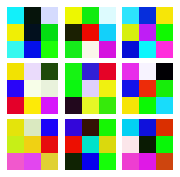

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

( 0 ,.,.) = 
1.00000e-02 *
  2.5297  1.7423  2.5815
 -0.4672  1.9507 -1.4838
 -1.8215  2.2727  1.4220

( 1 ,.,.) = 
1.00000e-02 *
  1.1767 -1.8035  1.0978
 -0.2529 -1.5062  0.4242
 -1.0895 -0.7942  0.6386

( 2 ,.,.) = 
1.00000e-02 *
  0.4939  0.2196  2.8380
 -2.2302  2.8491  1.4498
 -2.8430 -1.0170  0.3569
... 

(125,.,.) = 
1.00000e-02 *
  2.6015  0.5586 -1.4878
  2.1719  1.1727 -2.5250
  0.7588  2.6193  0.0770

(126,.,.) = 
1.00000e-02 *
  1.2763 -1.9226 -2.0797
  1.0606 -2.6548  2.4985
  0.4864 -2.8808  1.1926

(127,.,.) = 
1.00000e-02 *
 -1.3269 -1.6996  2.9455
 -0.9755  1.7934  2.3184
 -1.8557 -1.3715  1.1300
[torch.FloatTensor of size 128x3x3]

i=  1

( 0 ,.,.) = 
1.00000e-02 *
 -2.7614 -1.2644 -2.5762
 -1.0978 -0.9225 -0.6982
 -0.6705 -2.0045  2.0571

( 1 ,.,.) = 
1.00000e-02 *
  1.4258 -2.8654 -2.6956
 -2.4048 -2.6252


( 0 ,.,.) = 
1.00000e-02 *
  0.3352  1.8720  0.2563
 -2.2081  0.3336  2.6502
  1.8598  1.0065  1.8123

( 1 ,.,.) = 
1.00000e-02 *
  1.9901 -1.0912 -1.1571
  1.9460 -1.3994  2.8510
 -0.1287 -2.4378 -1.4550

( 2 ,.,.) = 
1.00000e-02 *
  1.0775 -2.4009 -2.7286
  0.4311  2.2773 -2.5076
 -0.7642  0.8986  0.4450
... 

(125,.,.) = 
1.00000e-02 *
  1.2963  2.6616 -1.1842
  2.2777 -2.8266 -1.0397
  0.8969 -0.3242 -2.4265

(126,.,.) = 
1.00000e-02 *
 -1.7131  1.1762  2.2097
 -0.8741 -1.2622 -2.2282
  2.7874  2.4705 -0.8236

(127,.,.) = 
1.00000e-02 *
 -0.4006 -1.9572 -0.2133
 -1.1197  0.6232  1.3952
 -0.6892 -2.1091  2.8617
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  0.3352  1.8720  0.2563
 -2.2081  0.3336  2.6502
  1.8598  1.0065  1.8123

( 1 ,.,.) = 
1.00000e-02 *
  1.9901 -1.0912 -1.1571
  1.9460 -1.3994  2.8510
 -0.1287 -2.4378 -1.4550

( 2 ,.,.) = 
1.00000e-02 *
  1.0775 -2.4009 -2.7286
  0.4311  2.2773 -2.5076
 -0.7642  0.8986  0.4450
... 

(125,.,.) = 
1.0000


( 0 ,.,.) = 
1.00000e-02 *
  0.3352  1.8720  0.2563
 -2.2081  0.3336  2.6502
  1.8598  1.0065  1.8123

( 1 ,.,.) = 
1.00000e-02 *
  1.9901 -1.0912 -1.1571
  1.9460 -1.3994  2.8510
 -0.1287 -2.4378 -1.4550

( 2 ,.,.) = 
1.00000e-02 *
  1.0775 -2.4009 -2.7286
  0.4311  2.2773 -2.5076
 -0.7642  0.8986  0.4450
... 

(125,.,.) = 
1.00000e-02 *
  1.2963  2.6616 -1.1842
  2.2777 -2.8266 -1.0397
  0.8969 -0.3242 -2.4265

(126,.,.) = 
1.00000e-02 *
 -1.7131  1.1762  2.2097
 -0.8741 -1.2622 -2.2282
  2.7874  2.4705 -0.8236

(127,.,.) = 
1.00000e-02 *
 -0.4006 -1.9572 -0.2133
 -1.1197  0.6232  1.3952
 -0.6892 -2.1091  2.8617
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  0.3352  1.8720  0.2563
 -2.2081  0.3336  2.6502
  1.8598  1.0065  1.8123

( 1 ,.,.) = 
1.00000e-02 *
  1.9901 -1.0912 -1.1571
  1.9460 -1.3994  2.8510
 -0.1287 -2.4378 -1.4550

( 2 ,.,.) = 
1.00000e-02 *
  1.0775 -2.4009 -2.7286
  0.4311  2.2773 -2.5076
 -0.7642  0.8986  0.4450
... 

(125,.,.) = 
1.0000

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  0.3352  1.8720  0.2563
 -2.2081  0.3336  2.6502
  1.8598  1.0065  1.8123

( 1 ,.,.) = 
1.00000e-02 *
  1.9901 -1.0912 -1.1571
  1.9460 -1.3994  2.8510
 -0.1287 -2.4378 -1.4550

( 2 ,.,.) = 
1.00000e-02 *
  1.0775 -2.4009 -2.7286
  0.4311  2.2773 -2.5076
 -0.7642  0.8986  0.4450
... 

(125,.,.) = 
1.00000e-02 *
  1.2963  2.6616 -1.1842
  2.2777 -2.8266 -1.0397
  0.8969 -0.3242 -2.4265

(126,.,.) = 
1.00000e-02 *
 -1.7131  1.1762  2.2097
 -0.8741 -1.2622 -2.2282
  2.7874  2.4705 -0.8236

(127,.,.) = 
1.00000e-02 *
 -0.4006 -1.9572 -0.2133
 -1.1197  0.6232  1.3952
 -0.6892 -2.1091  2.8617
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  0.3352  1.8720  0.2563
 -2.2081  0.3336  2.6502
  1.8598  1.0065  1.8123

( 1 ,.,.) = 
1.00000e-02 *
  1.9901 -1.0912 -1.1571
  1.9460 -1.3994  2.8510
 -0.1287 -2.4378 -1.4550

( 2 ,.,.) = 
1.00000e-02 *
  1.0775 -2.4009 -2.7286
  0.4311  2.2773 -2.5076
 -0.7642  0.8986  0.4450
... 

(125,.,.) = 


<Figure size 432x288 with 0 Axes>

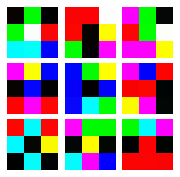

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

( 0 ,.,.) = 
1.00000e-02 *
 -0.8624 -2.3336  0.5834
  0.7030 -2.3546  2.6355
  1.9684 -0.2177 -2.2181

( 1 ,.,.) = 
1.00000e-02 *
 -1.6208 -2.3409 -0.4122
  1.9506 -2.2910  1.0126
 -2.6497 -1.1413  0.3877

( 2 ,.,.) = 
1.00000e-02 *
 -0.5075 -2.3315 -1.8330
 -2.0186  2.4223  1.3861
 -0.8407  1.5591  0.2062
... 

(125,.,.) = 
1.00000e-02 *
  1.8465 -2.2114  1.3011
 -2.0462  1.8148 -1.2414
  0.0465 -1.2202  1.7077

(126,.,.) = 
1.00000e-02 *
 -1.7929  1.1112  0.9394
 -1.3228 -1.9150 -2.8081
  2.4362 -0.2111 -0.2734

(127,.,.) = 
1.00000e-02 *
 -2.1861  1.5480 -2.2950
 -1.1750 -0.3412  1.5930
  2.8196  1.7335  1.5170
[torch.FloatTensor of size 128x3x3]

i=  1

( 0 ,.,.) = 
1.00000e-02 *
  2.5508  2.4389  1.4990
  1.8879  2.4956  0.6302
  2.7675  0.0948  2.9307

( 1 ,.,.) = 
1.00000e-02 *
 -0.3019  1.5732 -1.0251
 -2.7614  1.0286


( 0 ,.,.) = 
1.00000e-02 *
  1.5463 -1.8344  1.0433
 -2.7875  0.2890  0.4968
 -1.0740  2.3776 -2.0820

( 1 ,.,.) = 
1.00000e-02 *
  1.7057 -1.7317 -2.1678
  0.0185  2.1763 -0.3598
 -1.6284 -0.2786 -1.1044

( 2 ,.,.) = 
1.00000e-02 *
 -2.3733 -2.5480  0.6628
 -2.1322 -0.0159 -1.9313
 -0.9181  0.9355  0.3740
... 

(125,.,.) = 
1.00000e-02 *
  0.7477 -1.2068 -0.2587
 -2.6304  1.6935  1.7413
 -1.4318  0.0913  2.4224

(126,.,.) = 
1.00000e-02 *
 -2.7760  2.6560 -2.5255
 -2.3772 -0.0155 -2.0330
 -2.7916  1.7636  2.6277

(127,.,.) = 
1.00000e-02 *
  2.7937 -1.9386 -0.9263
  0.5468 -2.0796 -2.3559
  1.7945  2.7693 -0.4969
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.5463 -1.8344  1.0433
 -2.7875  0.2890  0.4968
 -1.0740  2.3776 -2.0820

( 1 ,.,.) = 
1.00000e-02 *
  1.7057 -1.7317 -2.1678
  0.0185  2.1763 -0.3598
 -1.6284 -0.2786 -1.1044

( 2 ,.,.) = 
1.00000e-02 *
 -2.3733 -2.5480  0.6628
 -2.1322 -0.0159 -1.9313
 -0.9181  0.9355  0.3740
... 

(125,.,.) = 
1.0000


( 0 ,.,.) = 
1.00000e-02 *
  1.5463 -1.8344  1.0433
 -2.7875  0.2890  0.4968
 -1.0740  2.3776 -2.0820

( 1 ,.,.) = 
1.00000e-02 *
  1.7057 -1.7317 -2.1678
  0.0185  2.1763 -0.3598
 -1.6284 -0.2786 -1.1044

( 2 ,.,.) = 
1.00000e-02 *
 -2.3733 -2.5480  0.6628
 -2.1322 -0.0159 -1.9313
 -0.9181  0.9355  0.3740
... 

(125,.,.) = 
1.00000e-02 *
  0.7477 -1.2068 -0.2587
 -2.6304  1.6935  1.7413
 -1.4318  0.0913  2.4224

(126,.,.) = 
1.00000e-02 *
 -2.7760  2.6560 -2.5255
 -2.3772 -0.0155 -2.0330
 -2.7916  1.7636  2.6277

(127,.,.) = 
1.00000e-02 *
  2.7937 -1.9386 -0.9263
  0.5468 -2.0796 -2.3559
  1.7945  2.7693 -0.4969
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.5463 -1.8344  1.0433
 -2.7875  0.2890  0.4968
 -1.0740  2.3776 -2.0820

( 1 ,.,.) = 
1.00000e-02 *
  1.7057 -1.7317 -2.1678
  0.0185  2.1763 -0.3598
 -1.6284 -0.2786 -1.1044

( 2 ,.,.) = 
1.00000e-02 *
 -2.3733 -2.5480  0.6628
 -2.1322 -0.0159 -1.9313
 -0.9181  0.9355  0.3740
... 

(125,.,.) = 
1.0000


( 0 ,.,.) = 
1.00000e-02 *
  1.5463 -1.8344  1.0433
 -2.7875  0.2890  0.4968
 -1.0740  2.3776 -2.0820

( 1 ,.,.) = 
1.00000e-02 *
  1.7057 -1.7317 -2.1678
  0.0185  2.1763 -0.3598
 -1.6284 -0.2786 -1.1044

( 2 ,.,.) = 
1.00000e-02 *
 -2.3733 -2.5480  0.6628
 -2.1322 -0.0159 -1.9313
 -0.9181  0.9355  0.3740
... 

(125,.,.) = 
1.00000e-02 *
  0.7477 -1.2068 -0.2587
 -2.6304  1.6935  1.7413
 -1.4318  0.0913  2.4224

(126,.,.) = 
1.00000e-02 *
 -2.7760  2.6560 -2.5255
 -2.3772 -0.0155 -2.0330
 -2.7916  1.7636  2.6277

(127,.,.) = 
1.00000e-02 *
  2.7937 -1.9386 -0.9263
  0.5468 -2.0796 -2.3559
  1.7945  2.7693 -0.4969
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.5463 -1.8344  1.0433
 -2.7875  0.2890  0.4968
 -1.0740  2.3776 -2.0820

( 1 ,.,.) = 
1.00000e-02 *
  1.7057 -1.7317 -2.1678
  0.0185  2.1763 -0.3598
 -1.6284 -0.2786 -1.1044

( 2 ,.,.) = 
1.00000e-02 *
 -2.3733 -2.5480  0.6628
 -2.1322 -0.0159 -1.9313
 -0.9181  0.9355  0.3740
... 

(125,.,.) = 
1.0000

<Figure size 432x288 with 0 Axes>

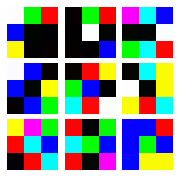

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

( 0 ,.,.) = 
1.00000e-02 *
 -1.3686  2.4451  0.5341
 -2.8649 -0.0319  1.1384
  1.9496  2.8729 -0.4210

( 1 ,.,.) = 
1.00000e-02 *
  1.1783  0.4571  2.3966
 -1.2588 -0.6875 -0.7785
  0.6787  1.3938 -2.6712

( 2 ,.,.) = 
1.00000e-02 *
 -2.5397  0.7716 -0.6119
 -1.2896  2.8378 -0.3581
  1.5324  2.3422  1.0172
... 

(125,.,.) = 
1.00000e-02 *
 -2.3223  1.9831  1.6289
  1.4893  0.1080 -0.5947
  0.2732  0.1449 -0.9193

(126,.,.) = 
1.00000e-02 *
 -2.9212 -0.4277 -0.0367
 -1.0727 -2.0404  2.5154
 -1.6234  1.1531  0.1673

(127,.,.) = 
1.00000e-02 *
  0.6744  0.4698  1.0850
  0.8687 -0.9564 -1.7266
 -2.6714  0.7599 -0.1541
[torch.FloatTensor of size 128x3x3]

i=  1

( 0 ,.,.) = 
1.00000e-02 *
 -2.9281 -1.1747  2.6822
 -2.1327  1.5809 -2.0533
  2.7143  2.7329  2.1962

( 1 ,.,.) = 
1.00000e-02 *
 -0.5009 -1.6180 -2.4281
 -2.5936 -2.0013

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.5180 -1.5680 -1.0443
 -0.5327  0.3620 -1.3497
 -0.6752  2.1768 -1.4390

( 1 ,.,.) = 
1.00000e-02 *
 -0.1180  2.2414  0.5362
  2.3159 -1.7510  2.2597
  2.7354  1.4792  2.3225

( 2 ,.,.) = 
1.00000e-02 *
 -2.0780  1.7711 -2.4991
 -2.3298  0.9306  1.4865
  2.1703  2.2777 -2.5388
... 

(125,.,.) = 
1.00000e-02 *
 -2.7709 -0.7383  0.5395
  2.1019 -2.4896  1.0771
  2.2887 -0.5020 -2.1120

(126,.,.) = 
1.00000e-02 *
  2.0180 -2.2603 -2.7889
  0.7861 -2.9160  2.6106
 -2.0788  1.8235 -1.1855

(127,.,.) = 
1.00000e-02 *
  1.8942  2.5404  1.5208
  0.0632  2.3426  2.1962
 -2.0887 -0.5560  0.8046
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.5180 -1.5680 -1.0443
 -0.5327  0.3620 -1.3497
 -0.6752  2.1768 -1.4390

( 1 ,.,.) = 
1.00000e-02 *
 -0.1180  2.2414  0.5362
  2.3159 -1.7510  2.2597
  2.7354  1.4792  2.3225

( 2 ,.,.) = 
1.00000e-02 *
 -2.0780  1.7711 -2.4991
 -2.3298  0.9306  1.4865
  2.1703  2.2777 -2.5388
... 

(125,.,.) = 


i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.5180 -1.5680 -1.0443
 -0.5327  0.3620 -1.3497
 -0.6752  2.1768 -1.4390

( 1 ,.,.) = 
1.00000e-02 *
 -0.1180  2.2414  0.5362
  2.3159 -1.7510  2.2597
  2.7354  1.4792  2.3225

( 2 ,.,.) = 
1.00000e-02 *
 -2.0780  1.7711 -2.4991
 -2.3298  0.9306  1.4865
  2.1703  2.2777 -2.5388
... 

(125,.,.) = 
1.00000e-02 *
 -2.7709 -0.7383  0.5395
  2.1019 -2.4896  1.0771
  2.2887 -0.5020 -2.1120

(126,.,.) = 
1.00000e-02 *
  2.0180 -2.2603 -2.7889
  0.7861 -2.9160  2.6106
 -2.0788  1.8235 -1.1855

(127,.,.) = 
1.00000e-02 *
  1.8942  2.5404  1.5208
  0.0632  2.3426  2.1962
 -2.0887 -0.5560  0.8046
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.5180 -1.5680 -1.0443
 -0.5327  0.3620 -1.3497
 -0.6752  2.1768 -1.4390

( 1 ,.,.) = 
1.00000e-02 *
 -0.1180  2.2414  0.5362
  2.3159 -1.7510  2.2597
  2.7354  1.4792  2.3225

( 2 ,.,.) = 
1.00000e-02 *
 -2.0780  1.7711 -2.4991
 -2.3298  0.9306  1.4865
  2.1703  2.2777 -2.5388
... 

(125,.,.) = 



( 0 ,.,.) = 
1.00000e-02 *
  1.5180 -1.5680 -1.0443
 -0.5327  0.3620 -1.3497
 -0.6752  2.1768 -1.4390

( 1 ,.,.) = 
1.00000e-02 *
 -0.1180  2.2414  0.5362
  2.3159 -1.7510  2.2597
  2.7354  1.4792  2.3225

( 2 ,.,.) = 
1.00000e-02 *
 -2.0780  1.7711 -2.4991
 -2.3298  0.9306  1.4865
  2.1703  2.2777 -2.5388
... 

(125,.,.) = 
1.00000e-02 *
 -2.7709 -0.7383  0.5395
  2.1019 -2.4896  1.0771
  2.2887 -0.5020 -2.1120

(126,.,.) = 
1.00000e-02 *
  2.0180 -2.2603 -2.7889
  0.7861 -2.9160  2.6106
 -2.0788  1.8235 -1.1855

(127,.,.) = 
1.00000e-02 *
  1.8942  2.5404  1.5208
  0.0632  2.3426  2.1962
 -2.0887 -0.5560  0.8046
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.5180 -1.5680 -1.0443
 -0.5327  0.3620 -1.3497
 -0.6752  2.1768 -1.4390

( 1 ,.,.) = 
1.00000e-02 *
 -0.1180  2.2414  0.5362
  2.3159 -1.7510  2.2597
  2.7354  1.4792  2.3225

( 2 ,.,.) = 
1.00000e-02 *
 -2.0780  1.7711 -2.4991
 -2.3298  0.9306  1.4865
  2.1703  2.2777 -2.5388
... 

(125,.,.) = 
1.0000

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.5180 -1.5680 -1.0443
 -0.5327  0.3620 -1.3497
 -0.6752  2.1768 -1.4390

( 1 ,.,.) = 
1.00000e-02 *
 -0.1180  2.2414  0.5362
  2.3159 -1.7510  2.2597
  2.7354  1.4792  2.3225

( 2 ,.,.) = 
1.00000e-02 *
 -2.0780  1.7711 -2.4991
 -2.3298  0.9306  1.4865
  2.1703  2.2777 -2.5388
... 

(125,.,.) = 
1.00000e-02 *
 -2.7709 -0.7383  0.5395
  2.1019 -2.4896  1.0771
  2.2887 -0.5020 -2.1120

(126,.,.) = 
1.00000e-02 *
  2.0180 -2.2603 -2.7889
  0.7861 -2.9160  2.6106
 -2.0788  1.8235 -1.1855

(127,.,.) = 
1.00000e-02 *
  1.8942  2.5404  1.5208
  0.0632  2.3426  2.1962
 -2.0887 -0.5560  0.8046
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.5180 -1.5680 -1.0443
 -0.5327  0.3620 -1.3497
 -0.6752  2.1768 -1.4390

( 1 ,.,.) = 
1.00000e-02 *
 -0.1180  2.2414  0.5362
  2.3159 -1.7510  2.2597
  2.7354  1.4792  2.3225

( 2 ,.,.) = 
1.00000e-02 *
 -2.0780  1.7711 -2.4991
 -2.3298  0.9306  1.4865
  2.1703  2.2777 -2.5388
... 

(125,.,.) = 


<Figure size 432x288 with 0 Axes>

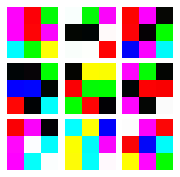

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

( 0 ,.,.) = 
1.00000e-02 *
  2.1484  2.5722  0.5309
  0.6827  0.5661  0.6288
  1.4588 -2.3726  0.6190

( 1 ,.,.) = 
1.00000e-02 *
  1.1211 -1.7544  2.5369
 -1.6378  2.0830 -0.4281
  0.7929 -2.9333 -2.5212

( 2 ,.,.) = 
1.00000e-02 *
 -0.9303  2.6349 -0.3875
  0.7875 -0.0251 -2.3713
  1.0150 -0.0517  0.1144
... 

(125,.,.) = 
1.00000e-02 *
 -2.1690  1.1951 -2.5370
  2.9273  1.4097 -2.7308
  2.7172 -1.0054 -1.5199

(126,.,.) = 
1.00000e-02 *
 -1.6741  1.7975 -1.6664
  0.5364 -0.5017 -0.5734
 -0.8149  2.5624 -2.3641

(127,.,.) = 
1.00000e-02 *
  1.9539  0.6117  1.4133
 -0.2780 -1.3056  0.0119
 -0.7940  0.2388  2.7809
[torch.FloatTensor of size 128x3x3]

i=  1

( 0 ,.,.) = 
1.00000e-02 *
 -1.8807  0.2210  1.4716
  1.5770  0.9267 -1.8061
 -1.3936 -1.9057 -2.5528

( 1 ,.,.) = 
1.00000e-02 *
 -1.2163  0.3159 -1.0802
 -1.5352 -0.8140

i=  8

( 0 ,.,.) = 
1.00000e-02 *
 -2.2585 -1.0889 -1.5061
 -0.9684  2.4631  2.4879
 -0.4864 -2.4003 -0.3361

( 1 ,.,.) = 
1.00000e-02 *
  1.4799  0.5074  2.8849
  0.8481  2.6214 -0.1120
  0.8821  2.3069 -2.7514

( 2 ,.,.) = 
1.00000e-02 *
  2.0204  0.8969 -1.6003
 -2.6420  0.1369  1.0139
 -2.6227 -0.7176 -0.7884
... 

(125,.,.) = 
1.00000e-02 *
 -0.8459 -2.8475  1.9725
  1.7679 -1.8203  1.1279
  0.8209 -1.1896 -0.3122

(126,.,.) = 
1.00000e-02 *
  0.8839  1.0178  0.3342
 -0.9444  2.1122 -1.7873
  1.7139 -1.1263 -0.7222

(127,.,.) = 
1.00000e-02 *
  2.7558  0.1626  0.0539
  0.8344 -1.9758 -0.2147
 -2.7472 -2.0432  1.6800
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
 -2.2585 -1.0889 -1.5061
 -0.9684  2.4631  2.4879
 -0.4864 -2.4003 -0.3361

( 1 ,.,.) = 
1.00000e-02 *
  1.4799  0.5074  2.8849
  0.8481  2.6214 -0.1120
  0.8821  2.3069 -2.7514

( 2 ,.,.) = 
1.00000e-02 *
  2.0204  0.8969 -1.6003
 -2.6420  0.1369  1.0139
 -2.6227 -0.7176 -0.7884
... 

(125,.,.) = 



( 0 ,.,.) = 
1.00000e-02 *
 -2.2585 -1.0889 -1.5061
 -0.9684  2.4631  2.4879
 -0.4864 -2.4003 -0.3361

( 1 ,.,.) = 
1.00000e-02 *
  1.4799  0.5074  2.8849
  0.8481  2.6214 -0.1120
  0.8821  2.3069 -2.7514

( 2 ,.,.) = 
1.00000e-02 *
  2.0204  0.8969 -1.6003
 -2.6420  0.1369  1.0139
 -2.6227 -0.7176 -0.7884
... 

(125,.,.) = 
1.00000e-02 *
 -0.8459 -2.8475  1.9725
  1.7679 -1.8203  1.1279
  0.8209 -1.1896 -0.3122

(126,.,.) = 
1.00000e-02 *
  0.8839  1.0178  0.3342
 -0.9444  2.1122 -1.7873
  1.7139 -1.1263 -0.7222

(127,.,.) = 
1.00000e-02 *
  2.7558  0.1626  0.0539
  0.8344 -1.9758 -0.2147
 -2.7472 -2.0432  1.6800
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
 -2.2585 -1.0889 -1.5061
 -0.9684  2.4631  2.4879
 -0.4864 -2.4003 -0.3361

( 1 ,.,.) = 
1.00000e-02 *
  1.4799  0.5074  2.8849
  0.8481  2.6214 -0.1120
  0.8821  2.3069 -2.7514

( 2 ,.,.) = 
1.00000e-02 *
  2.0204  0.8969 -1.6003
 -2.6420  0.1369  1.0139
 -2.6227 -0.7176 -0.7884
... 

(125,.,.) = 
1.0000


( 0 ,.,.) = 
1.00000e-02 *
 -2.2585 -1.0889 -1.5061
 -0.9684  2.4631  2.4879
 -0.4864 -2.4003 -0.3361

( 1 ,.,.) = 
1.00000e-02 *
  1.4799  0.5074  2.8849
  0.8481  2.6214 -0.1120
  0.8821  2.3069 -2.7514

( 2 ,.,.) = 
1.00000e-02 *
  2.0204  0.8969 -1.6003
 -2.6420  0.1369  1.0139
 -2.6227 -0.7176 -0.7884
... 

(125,.,.) = 
1.00000e-02 *
 -0.8459 -2.8475  1.9725
  1.7679 -1.8203  1.1279
  0.8209 -1.1896 -0.3122

(126,.,.) = 
1.00000e-02 *
  0.8839  1.0178  0.3342
 -0.9444  2.1122 -1.7873
  1.7139 -1.1263 -0.7222

(127,.,.) = 
1.00000e-02 *
  2.7558  0.1626  0.0539
  0.8344 -1.9758 -0.2147
 -2.7472 -2.0432  1.6800
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
 -2.2585 -1.0889 -1.5061
 -0.9684  2.4631  2.4879
 -0.4864 -2.4003 -0.3361

( 1 ,.,.) = 
1.00000e-02 *
  1.4799  0.5074  2.8849
  0.8481  2.6214 -0.1120
  0.8821  2.3069 -2.7514

( 2 ,.,.) = 
1.00000e-02 *
  2.0204  0.8969 -1.6003
 -2.6420  0.1369  1.0139
 -2.6227 -0.7176 -0.7884
... 

(125,.,.) = 
1.0000

<Figure size 432x288 with 0 Axes>

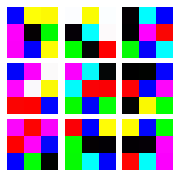

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

( 0 ,.,.) = 
1.00000e-02 *
  1.9690 -2.8814 -0.1529
 -0.1160  1.8095  0.9659
  0.4841 -2.1385 -1.2182

( 1 ,.,.) = 
1.00000e-02 *
  1.2101 -0.1527 -2.6064
 -0.5770 -2.8379  0.4575
 -2.3295  2.8462  0.8206

( 2 ,.,.) = 
1.00000e-02 *
 -1.8134  0.2901 -2.3688
 -1.8636 -2.9382 -0.6698
 -0.7463  1.9289 -2.0316
... 

(125,.,.) = 
1.00000e-02 *
 -1.9975  1.8516 -1.4970
 -1.5068 -2.8400 -1.6907
 -2.8399 -0.1149  1.3419

(126,.,.) = 
1.00000e-02 *
 -1.3628  1.3745  1.7580
 -2.1067  1.3809 -2.7598
  2.6357  2.3623 -2.0202

(127,.,.) = 
1.00000e-02 *
  0.4721  1.1845  0.9178
 -0.6691 -2.3666  0.6051
 -1.0645 -1.2344 -0.3710
[torch.FloatTensor of size 128x3x3]

i=  1

( 0 ,.,.) = 
1.00000e-02 *
 -0.3380  2.4535  1.8469
  0.2136 -1.0446 -2.2434
 -1.2169  2.3008  0.7446

( 1 ,.,.) = 
1.00000e-02 *
 -2.2024  0.0409  0.9195
 -2.0526 -0.8917

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.6768  0.6148  2.9433
  2.2518 -0.5517  0.6719
  0.1975  1.1843 -2.1921

( 1 ,.,.) = 
1.00000e-02 *
 -0.6904  0.3001  2.7237
 -0.5162  0.7832  1.3954
  0.0602 -1.3536  1.6646

( 2 ,.,.) = 
1.00000e-02 *
 -0.8375 -1.7324  1.7288
 -0.7093  2.2420 -0.6411
 -2.2806 -0.8042  0.9333
... 

(125,.,.) = 
1.00000e-02 *
 -1.3912  0.8371 -2.6046
  2.8234 -1.6431 -0.6991
 -0.0881  1.3155  1.1418

(126,.,.) = 
1.00000e-02 *
 -2.5879  2.4735 -0.1606
  2.8206  2.0974 -1.9641
  0.6726 -1.1408  2.4558

(127,.,.) = 
1.00000e-02 *
 -0.5115 -1.6889  2.3886
 -1.9948  1.7161  1.6070
  0.1407  2.2507 -1.6033
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.6768  0.6148  2.9433
  2.2518 -0.5517  0.6719
  0.1975  1.1843 -2.1921

( 1 ,.,.) = 
1.00000e-02 *
 -0.6904  0.3001  2.7237
 -0.5162  0.7832  1.3954
  0.0602 -1.3536  1.6646

( 2 ,.,.) = 
1.00000e-02 *
 -0.8375 -1.7324  1.7288
 -0.7093  2.2420 -0.6411
 -2.2806 -0.8042  0.9333
... 

(125,.,.) = 



( 0 ,.,.) = 
1.00000e-02 *
  1.6768  0.6148  2.9433
  2.2518 -0.5517  0.6719
  0.1975  1.1843 -2.1921

( 1 ,.,.) = 
1.00000e-02 *
 -0.6904  0.3001  2.7237
 -0.5162  0.7832  1.3954
  0.0602 -1.3536  1.6646

( 2 ,.,.) = 
1.00000e-02 *
 -0.8375 -1.7324  1.7288
 -0.7093  2.2420 -0.6411
 -2.2806 -0.8042  0.9333
... 

(125,.,.) = 
1.00000e-02 *
 -1.3912  0.8371 -2.6046
  2.8234 -1.6431 -0.6991
 -0.0881  1.3155  1.1418

(126,.,.) = 
1.00000e-02 *
 -2.5879  2.4735 -0.1606
  2.8206  2.0974 -1.9641
  0.6726 -1.1408  2.4558

(127,.,.) = 
1.00000e-02 *
 -0.5115 -1.6889  2.3886
 -1.9948  1.7161  1.6070
  0.1407  2.2507 -1.6033
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.6768  0.6148  2.9433
  2.2518 -0.5517  0.6719
  0.1975  1.1843 -2.1921

( 1 ,.,.) = 
1.00000e-02 *
 -0.6904  0.3001  2.7237
 -0.5162  0.7832  1.3954
  0.0602 -1.3536  1.6646

( 2 ,.,.) = 
1.00000e-02 *
 -0.8375 -1.7324  1.7288
 -0.7093  2.2420 -0.6411
 -2.2806 -0.8042  0.9333
... 

(125,.,.) = 
1.0000


( 0 ,.,.) = 
1.00000e-02 *
  1.6768  0.6148  2.9433
  2.2518 -0.5517  0.6719
  0.1975  1.1843 -2.1921

( 1 ,.,.) = 
1.00000e-02 *
 -0.6904  0.3001  2.7237
 -0.5162  0.7832  1.3954
  0.0602 -1.3536  1.6646

( 2 ,.,.) = 
1.00000e-02 *
 -0.8375 -1.7324  1.7288
 -0.7093  2.2420 -0.6411
 -2.2806 -0.8042  0.9333
... 

(125,.,.) = 
1.00000e-02 *
 -1.3912  0.8371 -2.6046
  2.8234 -1.6431 -0.6991
 -0.0881  1.3155  1.1418

(126,.,.) = 
1.00000e-02 *
 -2.5879  2.4735 -0.1606
  2.8206  2.0974 -1.9641
  0.6726 -1.1408  2.4558

(127,.,.) = 
1.00000e-02 *
 -0.5115 -1.6889  2.3886
 -1.9948  1.7161  1.6070
  0.1407  2.2507 -1.6033
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  1.6768  0.6148  2.9433
  2.2518 -0.5517  0.6719
  0.1975  1.1843 -2.1921

( 1 ,.,.) = 
1.00000e-02 *
 -0.6904  0.3001  2.7237
 -0.5162  0.7832  1.3954
  0.0602 -1.3536  1.6646

( 2 ,.,.) = 
1.00000e-02 *
 -0.8375 -1.7324  1.7288
 -0.7093  2.2420 -0.6411
 -2.2806 -0.8042  0.9333
... 

(125,.,.) = 
1.0000

<Figure size 432x288 with 0 Axes>

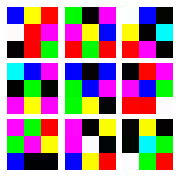

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.
i=  0

( 0 ,.,.) = 
1.00000e-02 *
  1.6534  0.4649  1.5790
 -0.9469  0.4223  1.2141
  1.2287  0.0041 -1.1666

( 1 ,.,.) = 
1.00000e-02 *
 -2.5630 -0.8032  2.5112
  2.0471  2.0150 -1.5172
 -0.3031  0.9530 -1.0363

( 2 ,.,.) = 
1.00000e-02 *
 -2.4713 -1.2202 -2.4924
  0.5553 -1.4422  2.4463
 -0.9456  2.4458  0.5115
... 

(125,.,.) = 
1.00000e-02 *
 -1.0697 -1.1457 -0.6442
 -0.3791 -0.2102 -1.0270
  1.3170 -0.0863  2.7909

(126,.,.) = 
1.00000e-02 *
  0.6999 -2.2968  2.5732
 -0.6926  0.0972  1.8382
 -2.8155 -2.0944 -1.5795

(127,.,.) = 
1.00000e-02 *
  1.9669  0.1732 -1.4012
 -2.6547 -0.9363  2.4252
  1.4975  2.0080  1.8208
[torch.FloatTensor of size 128x3x3]

i=  1

( 0 ,.,.) = 
1.00000e-02 *
 -0.4874  1.1167 -2.7642
  0.1130 -0.1088  1.8514
 -2.0076  1.7256 -1.4851

( 1 ,.,.) = 
1.00000e-02 *
  0.6377  0.4568  0.0767
  1.4060 -1.3280


( 0 ,.,.) = 
1.00000e-02 *
  0.9554 -0.8942  0.4141
  2.1365 -2.3867  2.7726
  2.6599 -1.6405  2.0198

( 1 ,.,.) = 
1.00000e-02 *
  0.1810  1.7111  0.2001
  1.6743 -0.8425 -1.6805
  2.5806  0.1377  1.1225

( 2 ,.,.) = 
1.00000e-02 *
  2.1850  0.6255  2.3789
  2.0843 -2.7349 -2.7486
  0.8670  0.0154  1.1243
... 

(125,.,.) = 
1.00000e-02 *
  0.1685 -1.8459  0.4307
 -0.4155  1.4816 -2.2223
  0.9918  1.1399  0.0869

(126,.,.) = 
1.00000e-02 *
  2.7085  2.3677 -2.2212
  2.8577 -0.3710  2.5047
 -0.4605  0.4831  2.6613

(127,.,.) = 
1.00000e-02 *
  2.5398  1.7410 -1.9475
  2.9262  0.5922  2.5435
 -1.7449 -0.7996  0.3470
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  0.9554 -0.8942  0.4141
  2.1365 -2.3867  2.7726
  2.6599 -1.6405  2.0198

( 1 ,.,.) = 
1.00000e-02 *
  0.1810  1.7111  0.2001
  1.6743 -0.8425 -1.6805
  2.5806  0.1377  1.1225

( 2 ,.,.) = 
1.00000e-02 *
  2.1850  0.6255  2.3789
  2.0843 -2.7349 -2.7486
  0.8670  0.0154  1.1243
... 

(125,.,.) = 
1.0000

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  0.9554 -0.8942  0.4141
  2.1365 -2.3867  2.7726
  2.6599 -1.6405  2.0198

( 1 ,.,.) = 
1.00000e-02 *
  0.1810  1.7111  0.2001
  1.6743 -0.8425 -1.6805
  2.5806  0.1377  1.1225

( 2 ,.,.) = 
1.00000e-02 *
  2.1850  0.6255  2.3789
  2.0843 -2.7349 -2.7486
  0.8670  0.0154  1.1243
... 

(125,.,.) = 
1.00000e-02 *
  0.1685 -1.8459  0.4307
 -0.4155  1.4816 -2.2223
  0.9918  1.1399  0.0869

(126,.,.) = 
1.00000e-02 *
  2.7085  2.3677 -2.2212
  2.8577 -0.3710  2.5047
 -0.4605  0.4831  2.6613

(127,.,.) = 
1.00000e-02 *
  2.5398  1.7410 -1.9475
  2.9262  0.5922  2.5435
 -1.7449 -0.7996  0.3470
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  0.9554 -0.8942  0.4141
  2.1365 -2.3867  2.7726
  2.6599 -1.6405  2.0198

( 1 ,.,.) = 
1.00000e-02 *
  0.1810  1.7111  0.2001
  1.6743 -0.8425 -1.6805
  2.5806  0.1377  1.1225

( 2 ,.,.) = 
1.00000e-02 *
  2.1850  0.6255  2.3789
  2.0843 -2.7349 -2.7486
  0.8670  0.0154  1.1243
... 

(125,.,.) = 



( 0 ,.,.) = 
1.00000e-02 *
  0.9554 -0.8942  0.4141
  2.1365 -2.3867  2.7726
  2.6599 -1.6405  2.0198

( 1 ,.,.) = 
1.00000e-02 *
  0.1810  1.7111  0.2001
  1.6743 -0.8425 -1.6805
  2.5806  0.1377  1.1225

( 2 ,.,.) = 
1.00000e-02 *
  2.1850  0.6255  2.3789
  2.0843 -2.7349 -2.7486
  0.8670  0.0154  1.1243
... 

(125,.,.) = 
1.00000e-02 *
  0.1685 -1.8459  0.4307
 -0.4155  1.4816 -2.2223
  0.9918  1.1399  0.0869

(126,.,.) = 
1.00000e-02 *
  2.7085  2.3677 -2.2212
  2.8577 -0.3710  2.5047
 -0.4605  0.4831  2.6613

(127,.,.) = 
1.00000e-02 *
  2.5398  1.7410 -1.9475
  2.9262  0.5922  2.5435
 -1.7449 -0.7996  0.3470
[torch.FloatTensor of size 128x3x3]

i=  8

( 0 ,.,.) = 
1.00000e-02 *
  0.9554 -0.8942  0.4141
  2.1365 -2.3867  2.7726
  2.6599 -1.6405  2.0198

( 1 ,.,.) = 
1.00000e-02 *
  0.1810  1.7111  0.2001
  1.6743 -0.8425 -1.6805
  2.5806  0.1377  1.1225

( 2 ,.,.) = 
1.00000e-02 *
  2.1850  0.6255  2.3789
  2.0843 -2.7349 -2.7486
  0.8670  0.0154  1.1243
... 

(125,.,.) = 
1.0000

<Figure size 432x288 with 0 Axes>

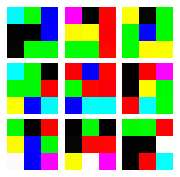

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.


<Figure size 432x288 with 0 Axes>

In [15]:
i = 0
for m in model.modules():
  if isinstance(m, nn.Conv2d):
    if i == 0:
      plot_kernels(m.weight.data)
      print("A sample to visualize weights.\n Here each element of 3x3 matrix represents the weights on each\n")
      print("kernel. The weights are color mapped, to understand better.")
      plt.savefig('result.png')

### Output Plots

Text(0.5, 1.0, 'Flower Classifier: Accuracy vs Epochs')

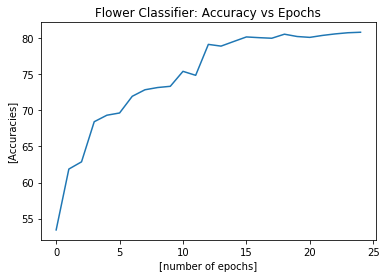

In [16]:
test_accuracies = [i*100 for i in test_accuracies]
# plot the training progress
plt.plot(range(0, len(test_accuracies)), test_accuracies)
plt.xlabel('[number of epochs]')
# plt.xlim([0, len(train_loss)])
plt.ylabel('[Accuracies]')
# plt.ylim([0.0, 1.0])
plt.title('CIFAR Classifier: Accuracy vs Epochs')

In [17]:
type(m.weight.data)

torch.FloatTensor

Text(0.5, 1.0, 'Flower Classifier: Loss vs Epochs')

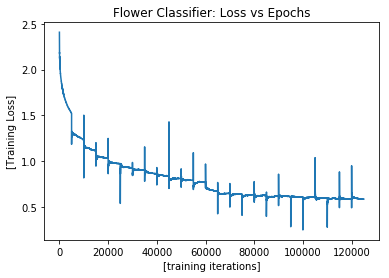

In [18]:
# test_accuracies = [i*100 for i in test_accuracies]
# plot the training progress
plt.plot(range(0, len(train_losses)), train_losses)
plt.xlabel('[training iterations]')
# plt.xlim([0, len(train_loss)])
plt.ylabel('[Training Loss]')
# plt.ylim([0.0, 1.0])
plt.title('CIFAR Classifier: Loss vs Epochs')